In [1]:
from matplotlib import pyplot as pl
%matplotlib inline
import pandas as pd
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.layers import SimpleRNN, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-08-22 02:21:40.751756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 02:21:40.850607: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import LCUtils_copy as LCU

In [3]:
rae_model = keras.models.load_model('trained_model')

2023-08-22 02:23:04.448471: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 02:23:04.878910: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22301 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:73:00.0, compute capability: 8.6


In [4]:
non_ringed_curves = np.loadtxt('non-ringed-shuffled-normalized-curves.txt')
index_2_thirds = int((2/3)*non_ringed_curves.shape[0])
non_ringed_test_medians = np.loadtxt('non-ringed-shuffled-medians.txt')[index_2_thirds:]
non_ringed_test_stds = np.loadtxt('non-ringed-shuffled-stds.txt')[index_2_thirds:]
non_ringed_test_ids = np.loadtxt('non-ringed-shuffled-ids.txt', str)[index_2_thirds:]
non_ringed_train_medians = np.loadtxt('non-ringed-shuffled-medians.txt')[:index_2_thirds]
non_ringed_train_stds = np.loadtxt('non-ringed-shuffled-stds.txt')[:index_2_thirds]
non_ringed_train_ids = np.loadtxt('non-ringed-shuffled-ids.txt', str)[:index_2_thirds]
np.nan_to_num(non_ringed_curves, copy=False)
test_non_ringed_curves = non_ringed_curves.reshape((non_ringed_curves.shape[0],non_ringed_curves.shape[1], 1))[index_2_thirds:]
train_non_ringed_curves = non_ringed_curves.reshape((non_ringed_curves.shape[0],non_ringed_curves.shape[1], 1))[:index_2_thirds]
predictions_non_ringed_curves = rae_model.predict(test_non_ringed_curves)
mean_predictions_non_ringed_curves = np.mean(predictions_non_ringed_curves, axis=2)
std_predictions_non_ringed_curves = np.std(predictions_non_ringed_curves, axis=2)
non_ringed_rec_err = np.sum(np.abs(test_non_ringed_curves[:, :, 0]-mean_predictions_non_ringed_curves),axis=1)/test_non_ringed_curves.shape[1]

mean_MSWD_non_ringed = []
for i in range(predictions_non_ringed_curves.shape[0]):
    MSWD_non_ringed=[]
    for j in range(predictions_non_ringed_curves.shape[1]):
        MSWD_non_ringed.append((1/(predictions_non_ringed_curves.shape[1]-1))*np.sum(((predictions_non_ringed_curves[i, j] - mean_predictions_non_ringed_curves[i])**2)/std_predictions_non_ringed_curves[i]**2))
    mean_MSWD_non_ringed.append(sum(MSWD_non_ringed)/predictions_non_ringed_curves.shape[1])

   1/2039 [..............................] - ETA: 1:00:50

2023-08-22 02:23:13.172591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-08-22 02:23:13.335294: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2039/2039 [==============================] - 28s 13ms/step


In [5]:
non_ringed_parameters = pd.read_csv('../../Datasets/non-ringed-parameters.csv', index_col='Unnamed: 0')
non_ringed_durations = non_ringed_parameters['pl_trandur'].values
non_ringed_transit_masks = np.loadtxt('../../Datasets/non-ringed-transit-masks.txt', int).astype(bool)
non_ringed_shuffled_indices = np.loadtxt('non-ringed-shuffled-indices.txt', int)
non_ringed_durations_test = non_ringed_durations[non_ringed_transit_masks][non_ringed_shuffled_indices][index_2_thirds:]

/tmp/ipykernel_283852/1129086656.py:3: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  non_ringed_transit_masks = np.loadtxt('../../Datasets/non-ringed-transit-masks.txt', int).astype(bool)


In [6]:
non_ringed_unnormalized_curves_test = []

for i in range(test_non_ringed_curves.shape[0]):
    non_ringed_unnormalized_curves_test.append((test_non_ringed_curves[i, :, 0]*non_ringed_test_stds[i]) + non_ringed_test_medians[i])
    
non_ringed_unnormalized_curves_test = np.vstack(non_ringed_unnormalized_curves_test)
non_ringed_transit_starts = LCU.get_transit_start(non_ringed_unnormalized_curves_test, 1800)

non_ringed_unnormalized_curves_train = []

for i in range(train_non_ringed_curves.shape[0]):
    non_ringed_unnormalized_curves_train.append((train_non_ringed_curves[i, :, 0]*non_ringed_train_stds[i]) + non_ringed_train_medians[i])
    
non_ringed_unnormalized_curves_train = np.vstack(non_ringed_unnormalized_curves_train)
non_ringed_transit_starts_train = LCU.get_transit_start(non_ringed_unnormalized_curves_train, 1800)


In [7]:
A_ringed_curves = np.loadtxt('Funky-initialized-data/A-ringed-shuffled-normalized-curves.txt')
A_ringed_medians = np.loadtxt('Funky-initialized-data/A-ringed-shuffled-medians.txt')
A_ringed_stds = np.loadtxt('Funky-initialized-data/A-ringed-shuffled-stds.txt')
A_ringed_ids = np.loadtxt('Funky-initialized-data/A-ringed-shuffled-ids.txt', str)
np.nan_to_num(A_ringed_curves, copy=False)
A_test_ringed_curves = A_ringed_curves.reshape((A_ringed_curves.shape[0], A_ringed_curves.shape[1], 1))
A_predictions_ringed_curves = rae_model.predict(A_test_ringed_curves)
A_mean_predictions_ringed_curves = np.mean(A_predictions_ringed_curves, axis=2)
A_std_predictions_ringed_curves = np.std(A_predictions_ringed_curves, axis=2)    
A_ringed_rec_err = np.sum(np.abs(A_test_ringed_curves[:, :, 0]-A_mean_predictions_ringed_curves),axis=1)/A_test_ringed_curves.shape[1]
A_rec_err_common_range = [np.min([np.nanmin(non_ringed_rec_err), np.nanmin(A_ringed_rec_err)]), np.nanmax([np.max(non_ringed_rec_err), np.nanmax(A_ringed_rec_err)])]

A_mean_MSWD_ringed = []

for i in range(A_predictions_ringed_curves.shape[0]):
    A_MSWD_ringed=[]
    for j in range(A_predictions_ringed_curves.shape[1]):
        A_MSWD_ringed.append((1/(A_predictions_ringed_curves.shape[1]-1))*np.sum(((A_predictions_ringed_curves[i, j] - A_mean_predictions_ringed_curves[i])**2)/A_std_predictions_ringed_curves[i]**2))
    A_mean_MSWD_ringed.append(sum(A_MSWD_ringed)/A_predictions_ringed_curves.shape[1])
    
A_mean_MSWD_common_range = [np.min([np.nanmin(A_mean_MSWD_ringed), np.nanmin(mean_MSWD_non_ringed)]), np.nanmax([np.max(A_mean_MSWD_ringed), np.nanmax(mean_MSWD_non_ringed)])]


31/31 [==============================] - 0s 13ms/step


In [8]:
A_ringed_unnormalized_curves = []
for i in range(A_test_ringed_curves.shape[0]):
    A_ringed_unnormalized_curves.append((A_test_ringed_curves[i, :, 0]*A_ringed_stds[i]) + A_ringed_medians[i])
    
A_ringed_unnormalized_curves = np.vstack(A_ringed_unnormalized_curves)
A_ringed_transit_starts = LCU.get_transit_start(A_ringed_unnormalized_curves, 1800)

In [9]:
B_ringed_curves = np.loadtxt('Funky-initialized-data/B-ringed-shuffled-normalized-curves.txt')
B_ringed_medians = np.loadtxt('Funky-initialized-data/B-ringed-shuffled-medians.txt')
B_ringed_stds = np.loadtxt('Funky-initialized-data/B-ringed-shuffled-stds.txt')
B_ringed_ids = np.loadtxt('Funky-initialized-data/B-ringed-shuffled-ids.txt', str)
np.nan_to_num(B_ringed_curves, copy=False)
B_test_ringed_curves = B_ringed_curves.reshape((B_ringed_curves.shape[0], B_ringed_curves.shape[1], 1))
B_predictions_ringed_curves = rae_model.predict(B_test_ringed_curves)
B_mean_predictions_ringed_curves = np.mean(B_predictions_ringed_curves, axis=2)
B_std_predictions_ringed_curves = np.std(B_predictions_ringed_curves, axis=2)    
B_ringed_rec_err = np.sum(np.abs(B_test_ringed_curves[:, :, 0]-B_mean_predictions_ringed_curves),axis=1)/B_test_ringed_curves.shape[1]
B_rec_err_common_range = [np.min([np.nanmin(non_ringed_rec_err), np.nanmin(B_ringed_rec_err)]), np.nanmax([np.max(non_ringed_rec_err), np.nanmax(B_ringed_rec_err)])]

B_mean_MSWD_ringed = []

for i in range(B_predictions_ringed_curves.shape[0]):
    B_MSWD_ringed=[]
    for j in range(B_predictions_ringed_curves.shape[1]):
        B_MSWD_ringed.append((1/(B_predictions_ringed_curves.shape[1]-1))*np.sum(((B_predictions_ringed_curves[i, j] - B_mean_predictions_ringed_curves[i])**2)/B_std_predictions_ringed_curves[i]**2))
    B_mean_MSWD_ringed.append(sum(B_MSWD_ringed)/B_predictions_ringed_curves.shape[1])
    
B_mean_MSWD_common_range = [np.min([np.nanmin(B_mean_MSWD_ringed), np.nanmin(mean_MSWD_non_ringed)]), np.nanmax([np.max(B_mean_MSWD_ringed), np.nanmax(mean_MSWD_non_ringed)])]




31/31 [==============================] - 0s 13ms/step


In [10]:
B_ringed_parameters = pd.read_csv('../../Datasets/Funky-rings/B-ringed-parameters.csv', index_col='Unnamed: 0')
B_ringed_durations = B_ringed_parameters['pl_trandur'].values
B_ringed_transit_masks = np.loadtxt('../../Datasets/Funky-rings/B-ringed-transit-masks.txt', int).astype(bool)
B_ringed_shuffled_indices = np.loadtxt('Funky-initialized-data/B-ringed-shuffled-indices.txt', int)
B_ringed_durations = B_ringed_durations[B_ringed_transit_masks][B_ringed_shuffled_indices]

/tmp/ipykernel_283852/331657436.py:3: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  B_ringed_transit_masks = np.loadtxt('../../Datasets/Funky-rings/B-ringed-transit-masks.txt', int).astype(bool)


In [11]:
B_ringed_unnormalized_curves = []
for i in range(B_test_ringed_curves.shape[0]):
    B_ringed_unnormalized_curves.append((B_test_ringed_curves[i, :, 0]*B_ringed_stds[i]) + B_ringed_medians[i])
    
B_ringed_unnormalized_curves = np.vstack(B_ringed_unnormalized_curves)
B_ringed_transit_starts = LCU.get_transit_start(B_ringed_unnormalized_curves, 1800)

In [12]:
C_ringed_curves = np.loadtxt('Funky-initialized-data/C-ringed-shuffled-normalized-curves.txt')
C_ringed_medians = np.loadtxt('Funky-initialized-data/C-ringed-shuffled-medians.txt')
C_ringed_stds = np.loadtxt('Funky-initialized-data/C-ringed-shuffled-stds.txt')
C_ringed_ids = np.loadtxt('Funky-initialized-data/C-ringed-shuffled-ids.txt', str)
np.nan_to_num(C_ringed_curves, copy=False)
C_test_ringed_curves = C_ringed_curves.reshape((C_ringed_curves.shape[0], C_ringed_curves.shape[1], 1))
C_predictions_ringed_curves = rae_model.predict(C_test_ringed_curves)
C_mean_predictions_ringed_curves = np.mean(C_predictions_ringed_curves, axis=2)
C_std_predictions_ringed_curves = np.std(C_predictions_ringed_curves, axis=2)    
C_ringed_rec_err = np.sum(np.abs(C_test_ringed_curves[:, :, 0]-C_mean_predictions_ringed_curves),axis=1)/C_test_ringed_curves.shape[1]
C_rec_err_common_range = [np.min([np.nanmin(non_ringed_rec_err), np.nanmin(C_ringed_rec_err)]), np.nanmax([np.max(non_ringed_rec_err), np.nanmax(C_ringed_rec_err)])]

C_mean_MSWD_ringed = []

for i in range(C_predictions_ringed_curves.shape[0]):
    C_MSWD_ringed=[]
    for j in range(C_predictions_ringed_curves.shape[1]):
        C_MSWD_ringed.append((1/(C_predictions_ringed_curves.shape[1]-1))*np.sum(((C_predictions_ringed_curves[i, j] - C_mean_predictions_ringed_curves[i])**2)/C_std_predictions_ringed_curves[i]**2))
    C_mean_MSWD_ringed.append(sum(C_MSWD_ringed)/C_predictions_ringed_curves.shape[1])
    
C_mean_MSWD_common_range = [np.min([np.nanmin(C_mean_MSWD_ringed), np.nanmin(mean_MSWD_non_ringed)]), np.nanmax([np.max(C_mean_MSWD_ringed), np.nanmax(mean_MSWD_non_ringed)])]


17/17 [==============================] - 0s 13ms/step


In [13]:
C_ringed_unnormalized_curves = []
for i in range(C_test_ringed_curves.shape[0]):
    C_ringed_unnormalized_curves.append((C_test_ringed_curves[i, :, 0]*C_ringed_stds[i]) + C_ringed_medians[i])
    
C_ringed_unnormalized_curves = np.vstack(C_ringed_unnormalized_curves)
C_ringed_transit_starts = LCU.get_transit_start(C_ringed_unnormalized_curves, 1800)

In [14]:
D_ringed_curves = np.loadtxt('Funky-initialized-data/D-ringed-shuffled-normalized-curves.txt')
D_ringed_medians = np.loadtxt('Funky-initialized-data/D-ringed-shuffled-medians.txt')
D_ringed_stds = np.loadtxt('Funky-initialized-data/D-ringed-shuffled-stds.txt')
D_ringed_ids = np.loadtxt('Funky-initialized-data/D-ringed-shuffled-ids.txt', str)
np.nan_to_num(D_ringed_curves, copy=False)
D_test_ringed_curves = D_ringed_curves.reshape((D_ringed_curves.shape[0], D_ringed_curves.shape[1], 1))
D_predictions_ringed_curves = rae_model.predict(D_test_ringed_curves)
D_mean_predictions_ringed_curves = np.mean(D_predictions_ringed_curves, axis=2)
D_std_predictions_ringed_curves = np.std(D_predictions_ringed_curves, axis=2)    
D_ringed_rec_err = np.sum(np.abs(D_test_ringed_curves[:, :, 0]-D_mean_predictions_ringed_curves),axis=1)/D_test_ringed_curves.shape[1]
D_rec_err_common_range = [np.min([np.nanmin(non_ringed_rec_err), np.nanmin(D_ringed_rec_err)]), np.nanmax([np.max(non_ringed_rec_err), np.nanmax(D_ringed_rec_err)])]

D_mean_MSWD_ringed = []

for i in range(D_predictions_ringed_curves.shape[0]):
    D_MSWD_ringed=[]
    for j in range(D_predictions_ringed_curves.shape[1]):
        D_MSWD_ringed.append((1/(D_predictions_ringed_curves.shape[1]-1))*np.sum(((D_predictions_ringed_curves[i, j] - D_mean_predictions_ringed_curves[i])**2)/D_std_predictions_ringed_curves[i]**2))
    D_mean_MSWD_ringed.append(sum(D_MSWD_ringed)/D_predictions_ringed_curves.shape[1])
    
D_mean_MSWD_common_range = [np.min([np.nanmin(D_mean_MSWD_ringed), np.nanmin(mean_MSWD_non_ringed)]), np.nanmax([np.max(D_mean_MSWD_ringed), np.nanmax(mean_MSWD_non_ringed)])]


17/17 [==============================] - 0s 13ms/step


In [15]:
D_ringed_unnormalized_curves = []
for i in range(D_test_ringed_curves.shape[0]):
    D_ringed_unnormalized_curves.append((D_test_ringed_curves[i, :, 0]*D_ringed_stds[i]) + D_ringed_medians[i])
    
D_ringed_unnormalized_curves = np.vstack(D_ringed_unnormalized_curves)
D_ringed_transit_starts = LCU.get_transit_start(D_ringed_unnormalized_curves, 1800)

In [16]:
E_ringed_curves = np.loadtxt('Funky-initialized-data/E-ringed-shuffled-normalized-curves.txt')
E_ringed_medians = np.loadtxt('Funky-initialized-data/E-ringed-shuffled-medians.txt')
E_ringed_stds = np.loadtxt('Funky-initialized-data/E-ringed-shuffled-stds.txt')
E_ringed_ids = np.loadtxt('Funky-initialized-data/E-ringed-shuffled-ids.txt', str)
np.nan_to_num(E_ringed_curves, copy=False)
E_test_ringed_curves = E_ringed_curves.reshape((E_ringed_curves.shape[0], E_ringed_curves.shape[1], 1))
E_predictions_ringed_curves = rae_model.predict(E_test_ringed_curves)
E_mean_predictions_ringed_curves = np.mean(E_predictions_ringed_curves, axis=2)
E_std_predictions_ringed_curves = np.std(E_predictions_ringed_curves, axis=2)    
E_ringed_rec_err = np.sum(np.abs(E_test_ringed_curves[:, :, 0]-E_mean_predictions_ringed_curves),axis=1)/E_test_ringed_curves.shape[1]
E_rec_err_common_range = [np.min([np.nanmin(non_ringed_rec_err), np.nanmin(E_ringed_rec_err)]), np.nanmax([np.max(non_ringed_rec_err), np.nanmax(E_ringed_rec_err)])]

E_mean_MSWD_ringed = []

for i in range(E_predictions_ringed_curves.shape[0]):
    E_MSWD_ringed=[]
    for j in range(E_predictions_ringed_curves.shape[1]):
        E_MSWD_ringed.append((1/(E_predictions_ringed_curves.shape[1]-1))*np.sum(((E_predictions_ringed_curves[i, j] - E_mean_predictions_ringed_curves[i])**2)/E_std_predictions_ringed_curves[i]**2))
    E_mean_MSWD_ringed.append(sum(E_MSWD_ringed)/E_predictions_ringed_curves.shape[1])
    
E_mean_MSWD_common_range = [np.min([np.nanmin(E_mean_MSWD_ringed), np.nanmin(mean_MSWD_non_ringed)]), np.nanmax([np.max(E_mean_MSWD_ringed), np.nanmax(mean_MSWD_non_ringed)])]


19/19 [==============================] - 0s 13ms/step


In [17]:
E_ringed_unnormalized_curves = []
for i in range(E_test_ringed_curves.shape[0]):
    E_ringed_unnormalized_curves.append((E_test_ringed_curves[i, :, 0]*E_ringed_stds[i]) + E_ringed_medians[i])
    
E_ringed_unnormalized_curves = np.vstack(E_ringed_unnormalized_curves)
E_ringed_transit_starts = LCU.get_transit_start(E_ringed_unnormalized_curves, 1800)

In [18]:
F_ringed_curves = np.loadtxt('Funky-initialized-data/F-ringed-shuffled-normalized-curves.txt')
F_ringed_medians = np.loadtxt('Funky-initialized-data/F-ringed-shuffled-medians.txt')
F_ringed_stds = np.loadtxt('Funky-initialized-data/F-ringed-shuffled-stds.txt')
F_ringed_ids = np.loadtxt('Funky-initialized-data/F-ringed-shuffled-ids.txt', str)
np.nan_to_num(F_ringed_curves, copy=False)
F_test_ringed_curves = F_ringed_curves.reshape((F_ringed_curves.shape[0], F_ringed_curves.shape[1], 1))
F_predictions_ringed_curves = rae_model.predict(F_test_ringed_curves)
F_mean_predictions_ringed_curves = np.mean(F_predictions_ringed_curves, axis=2)
F_std_predictions_ringed_curves = np.std(F_predictions_ringed_curves, axis=2)    
F_ringed_rec_err = np.sum(np.abs(F_test_ringed_curves[:, :, 0]-F_mean_predictions_ringed_curves),axis=1)/F_test_ringed_curves.shape[1]
F_rec_err_common_range = [np.min([np.nanmin(non_ringed_rec_err), np.nanmin(F_ringed_rec_err)]), np.nanmax([np.max(non_ringed_rec_err), np.nanmax(F_ringed_rec_err)])]

F_mean_MSWD_ringed = []

for i in range(F_predictions_ringed_curves.shape[0]):
    F_MSWD_ringed=[]
    for j in range(F_predictions_ringed_curves.shape[1]):
        F_MSWD_ringed.append((1/(F_predictions_ringed_curves.shape[1]-1))*np.sum(((F_predictions_ringed_curves[i, j] - F_mean_predictions_ringed_curves[i])**2)/F_std_predictions_ringed_curves[i]**2))
    F_mean_MSWD_ringed.append(sum(F_MSWD_ringed)/F_predictions_ringed_curves.shape[1])
    
F_mean_MSWD_common_range = [np.min([np.nanmin(F_mean_MSWD_ringed), np.nanmin(mean_MSWD_non_ringed)]), np.nanmax([np.max(F_mean_MSWD_ringed), np.nanmax(mean_MSWD_non_ringed)])]


19/19 [==============================] - 0s 12ms/step


In [19]:
F_ringed_unnormalized_curves = []
for i in range(F_test_ringed_curves.shape[0]):
    F_ringed_unnormalized_curves.append((F_test_ringed_curves[i, :, 0]*F_ringed_stds[i]) + F_ringed_medians[i])
    
F_ringed_unnormalized_curves = np.vstack(F_ringed_unnormalized_curves)
F_ringed_transit_starts = LCU.get_transit_start(F_ringed_unnormalized_curves, 1800)

In [20]:
G_ringed_curves = np.loadtxt('Funky-initialized-data/G-ringed-shuffled-normalized-curves.txt')
G_ringed_medians = np.loadtxt('Funky-initialized-data/G-ringed-shuffled-medians.txt')
G_ringed_stds = np.loadtxt('Funky-initialized-data/G-ringed-shuffled-stds.txt')
G_ringed_ids = np.loadtxt('Funky-initialized-data/G-ringed-shuffled-ids.txt', str)
np.nan_to_num(G_ringed_curves, copy=False)
G_test_ringed_curves = G_ringed_curves.reshape((G_ringed_curves.shape[0], G_ringed_curves.shape[1], 1))
G_predictions_ringed_curves = rae_model.predict(G_test_ringed_curves)
G_mean_predictions_ringed_curves = np.mean(G_predictions_ringed_curves, axis=2)
G_std_predictions_ringed_curves = np.std(G_predictions_ringed_curves, axis=2)    
G_ringed_rec_err = np.sum(np.abs(G_test_ringed_curves[:, :, 0]-G_mean_predictions_ringed_curves),axis=1)/G_test_ringed_curves.shape[1]
G_rec_err_common_range = [np.min([np.nanmin(non_ringed_rec_err), np.nanmin(G_ringed_rec_err)]), np.nanmax([np.max(non_ringed_rec_err), np.nanmax(G_ringed_rec_err)])]

G_mean_MSWD_ringed = []

for i in range(G_predictions_ringed_curves.shape[0]):
    G_MSWD_ringed=[]
    for j in range(G_predictions_ringed_curves.shape[1]):
        G_MSWD_ringed.append((1/(G_predictions_ringed_curves.shape[1]-1))*np.sum(((G_predictions_ringed_curves[i, j] - G_mean_predictions_ringed_curves[i])**2)/G_std_predictions_ringed_curves[i]))
    G_mean_MSWD_ringed.append(sum(G_MSWD_ringed)/G_predictions_ringed_curves.shape[1])
    
G_mean_MSWD_common_range = [np.min([np.nanmin(G_mean_MSWD_ringed), np.nanmin(mean_MSWD_non_ringed)]), np.nanmax([np.max(G_mean_MSWD_ringed), np.nanmax(mean_MSWD_non_ringed)])]


31/31 [==============================] - 0s 13ms/step


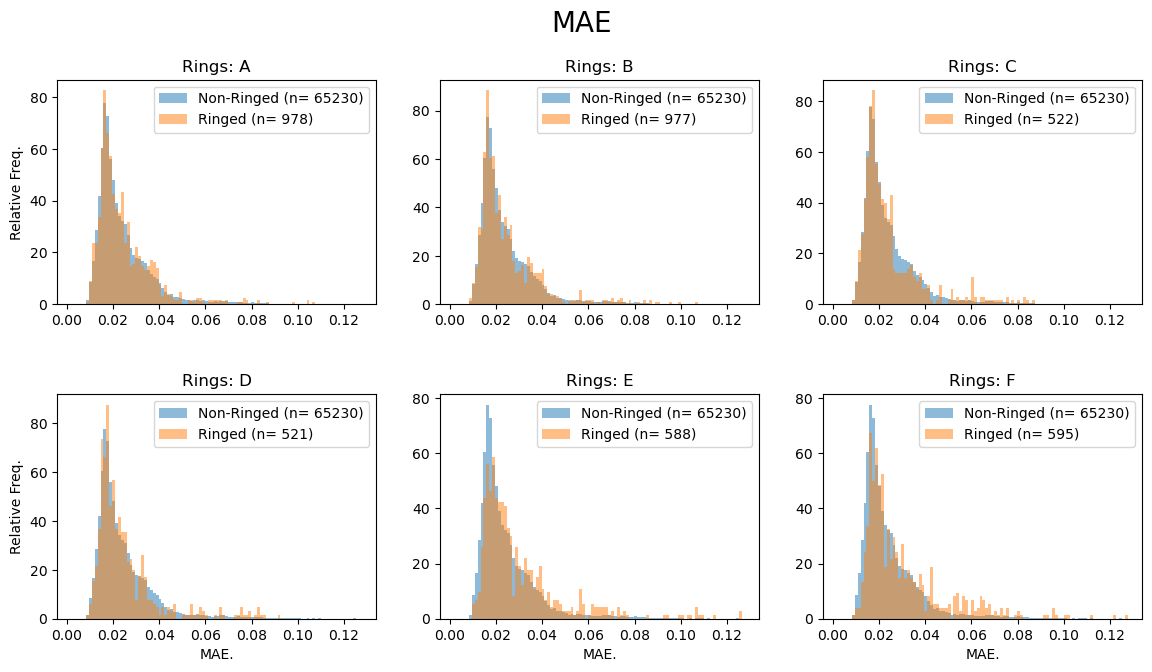

In [21]:
###Reconstruction Errors:
rec_errors = [A_ringed_rec_err,B_ringed_rec_err,C_ringed_rec_err,D_ringed_rec_err,E_ringed_rec_err,F_ringed_rec_err]
rec_errors_ranges = np.array([A_rec_err_common_range,B_rec_err_common_range,C_rec_err_common_range,D_rec_err_common_range,E_rec_err_common_range,F_rec_err_common_range])/4
letra = ['A', 'B', 'C','D','E','F']
N = [A_ringed_ids.shape[0],B_ringed_ids.shape[0],C_ringed_ids.shape[0],D_ringed_ids.shape[0],E_ringed_ids.shape[0],F_ringed_ids.shape[0]]
N_non = non_ringed_test_ids.shape[0]

fig, axes = pl.subplots(2, 3)

for i in range(6):
    if i < 3:
        axes[0, i].hist(non_ringed_rec_err, alpha=0.5, label='Non-Ringed (n= '+str(N_non)+')', bins=100, density=True, range=rec_errors_ranges[i])
        axes[0, i].hist(rec_errors[i], alpha=0.5, label='Ringed (n= '+str(N[i])+')', bins=100, density=True, range=rec_errors_ranges[i])
        axes[0, i].set_title('Rings: '+letra[i])
        axes[0, i].legend()
        
    if i >= 3:
        axes[1, i-3].hist(non_ringed_rec_err, alpha=0.5, label='Non-Ringed (n= '+str(N_non)+')', bins=100, density=True, range=rec_errors_ranges[i])
        axes[1, i-3].hist(rec_errors[i], alpha=0.5, label='Ringed (n= '+str(N[i])+')', bins=100, density=True, range=rec_errors_ranges[i])
        axes[1, i-3].set_title('Rings: '+letra[i])
        axes[1, i-3].legend()

        
axes[0, 0].set_ylabel('Relative Freq.')
axes[1, 0].set_ylabel('Relative Freq.')
axes[1, 0].set_xlabel('MAE.')
axes[1, 1].set_xlabel('MAE.')
axes[1, 2].set_xlabel('MAE.')
axes[0, 0].legend()
fig.suptitle('MAE', fontsize=20)
fig.set_size_inches(14, 7)
pl.subplots_adjust(hspace=0.4)
fig.savefig('Figs/Funky-figs/ABCDEF-rec-errs.png')
fig.show()

In [ ]:
###Reconstruction Errors:
rec_errors = [G_ringed_rec_err]
rec_errors_ranges = np.array([G_rec_err_common_range])/4
letra = ['G']
N = [G_ringed_ids.shape[0]]

fig, axes = pl.subplots(1, 1)

for i in range(1):
    axes.hist(non_ringed_rec_err, alpha=0.5, label='Non-Ringed (n= '+str(N_non)+')', bins=100, density=True, range=rec_errors_ranges[i])
    axes.hist(rec_errors[i], alpha=0.5, label='Ringed (n= '+str(N[i])+')', bins=100, density=True, range=rec_errors_ranges[i])
    axes.set_title('Funky rings: '+letra[i])
    axes.legend()      
        
    axes.set_ylabel('Relative Freq.')
    axes.set_yscale('log')
    axes.set_xlabel('Rec. Err.')

fig.suptitle('Reconstruction Error', fontsize=15)
fig.set_size_inches(7, 4)
fig.savefig('Figs/Funky-figs/G-rec-errs.png')
fig.show()

In [ ]:
###MSWD:
rec_errors = [G_mean_MSWD_ringed]
rec_errors_ranges = np.array([G_mean_MSWD_common_range])
letra = ['G']
N = [G_ringed_ids.shape[0]]

fig, axes = pl.subplots(1, 1)

for i in range(1):
    axes.hist(mean_MSWD_non_ringed, alpha=0.5, label='Non-Ringed (n= '+str(N_non)+')', bins=100, density=True, range=rec_errors_ranges[i])
    axes.hist(rec_errors[i], alpha=0.5, label='Ringed (n= '+str(N[i])+')', bins=100, density=True, range=rec_errors_ranges[i])
    axes.set_title('Funky rings: '+letra[i])
    axes.legend()      
        
    axes.set_ylabel('Relative Freq.')
    axes.set_yscale('log')
    axes.set_xlabel('Rec. Err.')

fig.suptitle('Reconstruction Error', fontsize=15)
fig.set_size_inches(7, 4)
fig.savefig('Figs/Funky-figs/G-rec-errs.png')
fig.show()

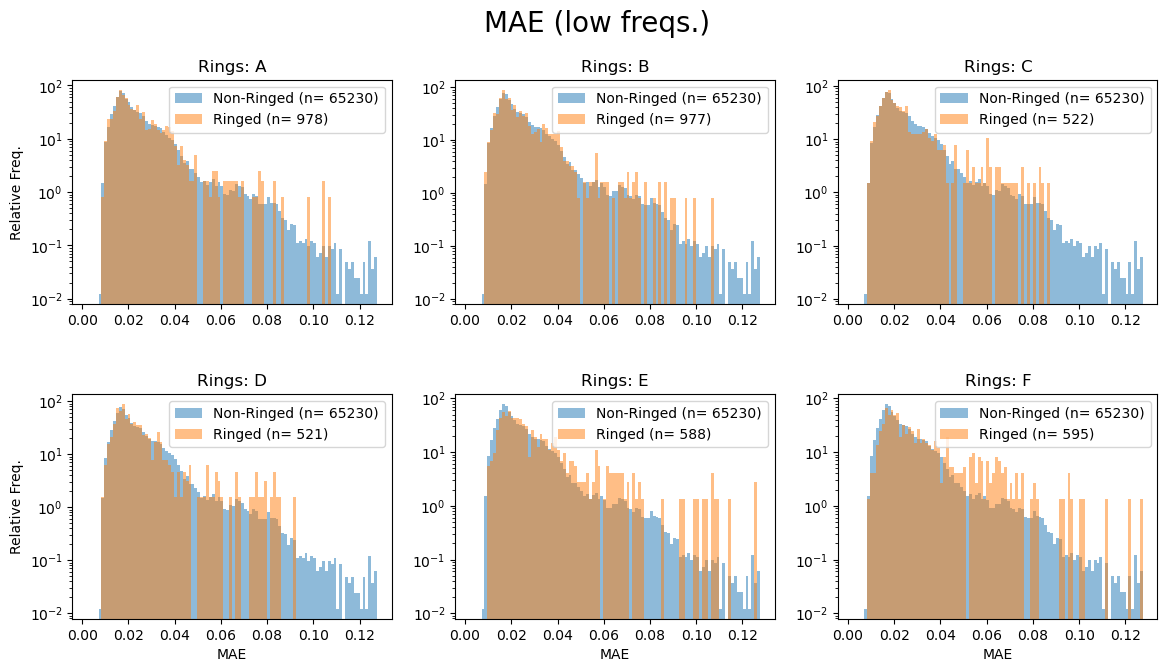

In [24]:
fig, axes = pl.subplots(2, 3)

for i in range(6):
    if i < 3:
        axes[0, i].hist(non_ringed_rec_err, alpha=0.5, label='Non-Ringed (n= '+str(N_non)+')', bins=100, density=True, range=rec_errors_ranges[i])
        axes[0, i].hist(rec_errors[i], alpha=0.5, label='Ringed (n= '+str(N[i])+')', bins=100, density=True, range=rec_errors_ranges[i])
        axes[0, i].set_title('Rings: '+letra[i])
        axes[0, i].set_yscale('log')
        axes[0, i].legend()
        
    if i >= 3:
        axes[1, i-3].hist(non_ringed_rec_err, alpha=0.5, label='Non-Ringed (n= '+str(N_non)+')', bins=100, density=True, range=rec_errors_ranges[i])
        axes[1, i-3].hist(rec_errors[i], alpha=0.5, label='Ringed (n= '+str(N[i])+')', bins=100, density=True, range=rec_errors_ranges[i])
        axes[1, i-3].set_title('Rings: '+letra[i])
        axes[1, i-3].set_yscale('log')
        axes[1, i-3].legend()

        
axes[0, 0].set_ylabel('Relative Freq.')
axes[1, 0].set_ylabel('Relative Freq.')
axes[1, 0].set_xlabel('MAE')
axes[1, 1].set_xlabel('MAE')
axes[1, 2].set_xlabel('MAE')
axes[0, 0].legend()
fig.suptitle('MAE (low freqs.)', fontsize=20)
pl.subplots_adjust(hspace=0.4)
fig.set_size_inches(14, 7)
fig.savefig('Figs/Funky-figs/ABCDEF-rec-errs-low-freq.png')
fig.show()

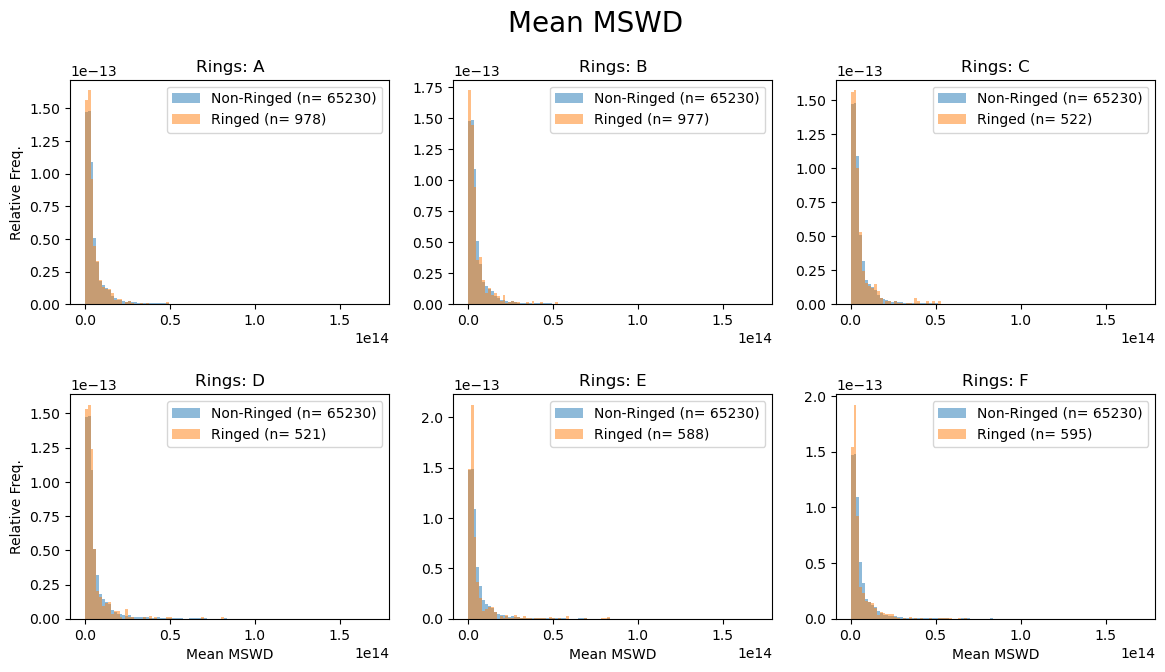

In [143]:
mean_MSWDs = [A_mean_MSWD_ringed,B_mean_MSWD_ringed,C_mean_MSWD_ringed,D_mean_MSWD_ringed,E_mean_MSWD_ringed,F_mean_MSWD_ringed]
mean_MSWDs_ranges = np.array([A_mean_MSWD_common_range,B_mean_MSWD_common_range,C_mean_MSWD_common_range,D_mean_MSWD_common_range,E_mean_MSWD_common_range,F_mean_MSWD_common_range])

fig, axes = pl.subplots(2, 3)

for i in range(6):
    if i < 3:
        axes[0, i].hist(mean_MSWD_non_ringed, alpha=0.5, label='Non-Ringed (n= '+str(N_non)+')', bins=100, density=True, range=mean_MSWDs_ranges[i])
        axes[0, i].hist(mean_MSWDs[i], alpha=0.5, label='Ringed (n= '+str(N[i])+')', bins=100, density=True, range=mean_MSWDs_ranges[i])
        axes[0, i].set_title('Rings: '+letra[i])
        axes[0, i].legend()
        
    if i >= 3:
        axes[1, i-3].hist(mean_MSWD_non_ringed, alpha=0.5, label='Non-Ringed (n= '+str(N_non)+')', bins=100, density=True, range=mean_MSWDs_ranges[i])
        axes[1, i-3].hist(mean_MSWDs[i], alpha=0.5, label='Ringed (n= '+str(N[i])+')', bins=100, density=True, range=mean_MSWDs_ranges[i])
        axes[1, i-3].set_title('Rings: '+letra[i])
        axes[1, i-3].legend()

        
axes[0, 0].set_ylabel('Relative Freq.')
axes[1, 0].set_ylabel('Relative Freq.')
axes[1, 0].set_xlabel('Mean MSWD')
axes[1, 1].set_xlabel('Mean MSWD')
axes[1, 2].set_xlabel('Mean MSWD')
axes[0, 0].legend()
fig.suptitle('Mean MSWD', fontsize=20)
pl.subplots_adjust(hspace=0.4)
fig.set_size_inches(14, 7)
fig.savefig('Figs/Funky-figs/ABCDEF-mean-MSWDs.png')
fig.show()

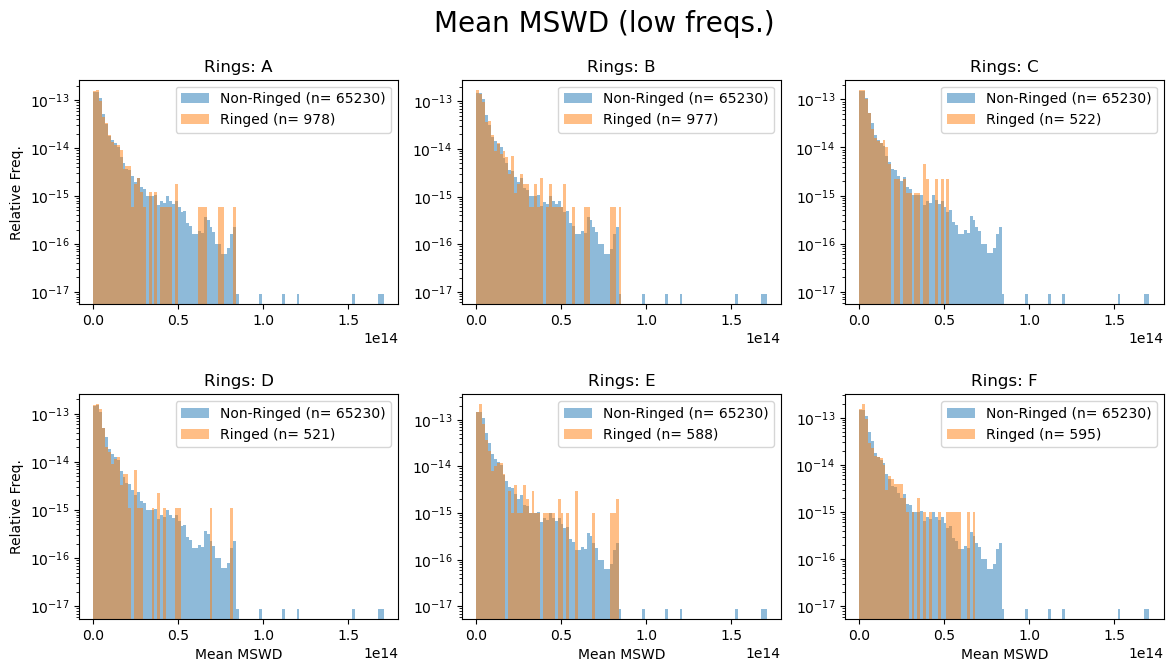

In [144]:
fig, axes = pl.subplots(2, 3)

for i in range(6):
    if i < 3:
        axes[0, i].hist(mean_MSWD_non_ringed, alpha=0.5, label='Non-Ringed (n= '+str(N_non)+')', bins=100, density=True, range=mean_MSWDs_ranges[i])
        axes[0, i].hist(mean_MSWDs[i], alpha=0.5, label='Ringed (n= '+str(N[i])+')', bins=100, density=True, range=mean_MSWDs_ranges[i])
        axes[0, i].set_title('Rings: '+letra[i])
        axes[0, i].legend()
        axes[0, i].set_yscale('log')
        
    if i >= 3:
        axes[1, i-3].hist(mean_MSWD_non_ringed, alpha=0.5, label='Non-Ringed (n= '+str(N_non)+')', bins=100, density=True, range=mean_MSWDs_ranges[i])
        axes[1, i-3].hist(mean_MSWDs[i], alpha=0.5, label='Ringed (n= '+str(N[i])+')', bins=100, density=True, range=mean_MSWDs_ranges[i])
        axes[1, i-3].set_title('Rings: '+letra[i])
        axes[1, i-3].legend()
        axes[1, i-3].set_yscale('log')

        
axes[0, 0].set_ylabel('Relative Freq.')
axes[1, 0].set_ylabel('Relative Freq.')
axes[1, 0].set_xlabel('Mean MSWD')
axes[1, 1].set_xlabel('Mean MSWD')
axes[1, 2].set_xlabel('Mean MSWD')
axes[0, 0].legend()
fig.suptitle('Mean MSWD (low freqs.)', fontsize=20)
pl.subplots_adjust(hspace=0.4)
fig.set_size_inches(14, 7)
fig.savefig('Figs/Funky-figs/ABCDEF-mean-MSWDs-low-freq.png')
fig.show()

In [ ]:
B_ringed_bad_mean_MSWD_mask = ((np.array(B_mean_MSWD_ringed) > 0.3*1e7) & (np.array(B_mean_MSWD_ringed) < 0.4*1e7))

fig, axes = pl.subplots(2, 3)
for i in range(6):
    B_ringed_real = (B_test_ringed_curves[B_ringed_bad_mean_MSWD_mask][i]*B_ringed_stds[B_ringed_bad_mean_MSWD_mask][i]) + B_ringed_medians[B_ringed_bad_mean_MSWD_mask][i]
    B_ringed_prediction = (B_mean_predictions_ringed_curves[B_ringed_bad_mean_MSWD_mask][i]*B_ringed_stds[B_ringed_bad_mean_MSWD_mask][i]) + B_ringed_medians[B_ringed_bad_mean_MSWD_mask][i]
    if i<3:
        axes[0, i].plot(np.linspace(0, 144, 145)/2,B_ringed_real,  '.', label='Original', markersize=2)
        axes[0, i].plot(np.linspace(0, 144, 145)/2,B_ringed_prediction,  label='Prediction', lw=0.5)
        axes[0, i].set_title(B_ringed_ids[B_ringed_bad_mean_MSWD_mask][i])

    if i>=3:
        axes[1, i-3].plot(np.linspace(0, 144, 145)/2,B_ringed_real,  '.', label='Original', markersize=2)
        axes[1, i-3].plot(np.linspace(0, 144, 145)/2,B_ringed_prediction,  label='Prediction', lw=0.5)
        axes[1, i-3].set_title(B_ringed_ids[B_ringed_bad_mean_MSWD_mask][i])
        
axes[0,0].set_ylabel('Normalized flux')
axes[1,0].set_ylabel('Normalized flux')
axes[1,0].set_xlabel('Hours')
axes[1,1].set_xlabel('Hours')
axes[1,2].set_xlabel('Hours')

        
fig.suptitle('Funky rings B: 0.3e7 < Mean MSWD < 0.4e7', fontsize=20)
fig.set_size_inches(14, 7)
fig.savefig('Figs/Funky-figs/B-bad-mean-MSWD-0.3-0.4.png')
fig.show()

In [ ]:
B_ringed_bad_mean_MSWD_mask = (np.array(B_mean_MSWD_ringed) > 0.4*1e7)

fig, axes = pl.subplots(2, 3)
for i in range(6):
    B_ringed_real = (B_test_ringed_curves[B_ringed_bad_mean_MSWD_mask][i]*B_ringed_stds[B_ringed_bad_mean_MSWD_mask][i]) + B_ringed_medians[B_ringed_bad_mean_MSWD_mask][i]
    B_ringed_prediction = (B_mean_predictions_ringed_curves[B_ringed_bad_mean_MSWD_mask][i]*B_ringed_stds[B_ringed_bad_mean_MSWD_mask][i]) + B_ringed_medians[B_ringed_bad_mean_MSWD_mask][i]
    if i<3:
        axes[0, i].plot(np.linspace(0, 144, 145)/2,B_ringed_real,  '.', label='Original', markersize=2)
        axes[0, i].plot(np.linspace(0, 144, 145)/2,B_ringed_prediction,  label='Prediction', lw=0.5)
        axes[0, i].set_title(B_ringed_ids[B_ringed_bad_mean_MSWD_mask][i])

    if i>=3:
        axes[1, i-3].plot(np.linspace(0, 144, 145)/2,B_ringed_real,  '.', label='Original', markersize=2)
        axes[1, i-3].plot(np.linspace(0, 144, 145)/2,B_ringed_prediction,  label='Prediction', lw=0.5)
        axes[1, i-3].set_title(B_ringed_ids[B_ringed_bad_mean_MSWD_mask][i])
        
axes[0,0].set_ylabel('Normalized flux')
axes[1,0].set_ylabel('Normalized flux')
axes[1,0].set_xlabel('Hours')
axes[1,1].set_xlabel('Hours')
axes[1,2].set_xlabel('Hours')

        
fig.suptitle('Funky rings B: 0.4e7 < Mean MSWD ', fontsize=20)
fig.set_size_inches(14, 7)
fig.savefig('Figs/Funky-figs/B-bad-mean-MSWD-0.4.png')
fig.show()

In [ ]:
pl.scatter(non_ringed_durations_test, mean_MSWD_non_ringed, s=5, label='Non-Ringed')
pl.scatter(B_ringed_durations, B_mean_MSWD_ringed, s=5, label='Ringed')
pl.title('Funky rings B: Transit duration vs. Mean MSWD.')
pl.xlabel('Transit duration [hrs]')
pl.ylabel('Mean MSWD')
pl.legend()
pl.savefig('Figs/Funky-figs/B-transit_duration-vs-mean-MSWD.png')
pl.show()

In [ ]:
pl.scatter(non_ringed_transit_starts, mean_MSWD_non_ringed, s=5, label='Non-Ringed')
pl.scatter(B_ringed_transit_starts, B_mean_MSWD_ringed, s=5, label='Ringed')
pl.title('Funky rings B: Start of transit vs. Mean MSWD.')
pl.xlabel('Start of transit [hrs]')
pl.ylabel('Mean MSWD')
pl.legend()

pl.show()

In [ ]:
pl.hist(non_ringed_transit_starts, bins=145)
pl.title('Non-Ringed test dataset:\nTime at which transit starts')
pl.xlabel('Hours')
pl.ylabel('Freq.')
pl.show()

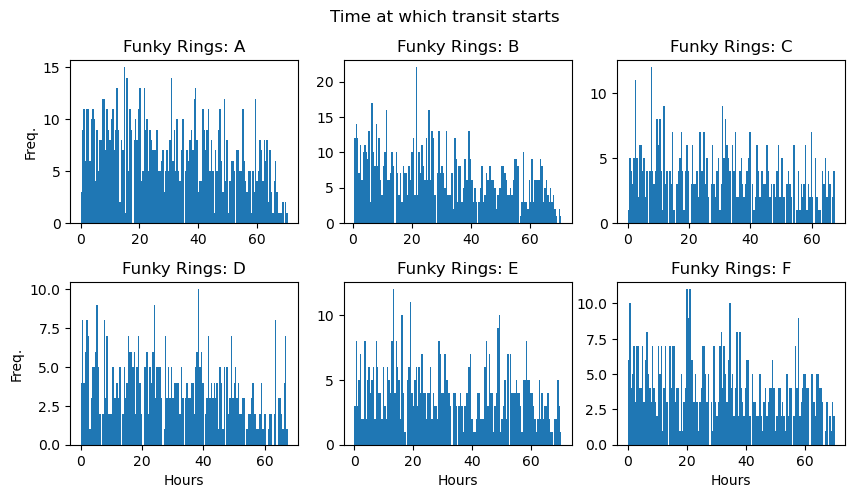

In [24]:
fig, axes = pl.subplots(2, 3)
axes[0, 0].hist(A_ringed_transit_starts, bins=145)
axes[0, 0].set_title('Funky Rings: A')
axes[0, 0].set_ylabel('Freq.')
axes[0, 1].hist(B_ringed_transit_starts, bins=145)
axes[0, 1].set_title('Funky Rings: B')
axes[0, 2].hist(C_ringed_transit_starts, bins=145)
axes[0, 2].set_title('Funky Rings: C')
axes[1, 0].hist(D_ringed_transit_starts, bins=145)
axes[1, 0].set_title('Funky Rings: D')
axes[1, 0].set_xlabel('Hours')
axes[1, 0].set_ylabel('Freq.')
axes[1, 1].hist(E_ringed_transit_starts, bins=145)
axes[1, 1].set_title('Funky Rings: E')
axes[1, 1].set_xlabel('Hours')
axes[1, 2].hist(F_ringed_transit_starts, bins=145)
axes[1, 2].set_title('Funky Rings: F')
axes[1, 2].set_xlabel('Hours')

pl.subplots_adjust(hspace=0.36)
fig.set_size_inches(10, 5)
fig.suptitle('Time at which transit starts')

fig.show()

In [ ]:
#####PLOTS PARA LA PRESENTACIÓN DE TESIS

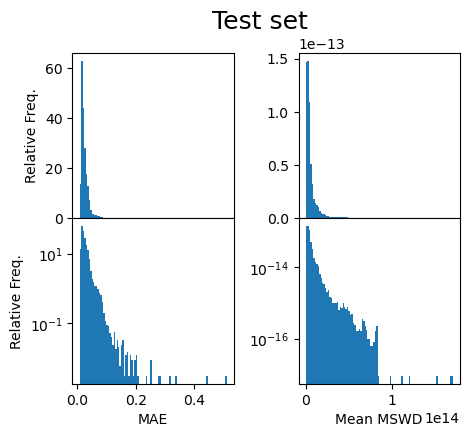

In [145]:
fig, ax = pl.subplots(2, 2)

ax[0, 0].hist(non_ringed_rec_err, label='Non-ringed', bins=100, density=True)
ax[0, 0].set_ylabel('Relative Freq.')
ax[0, 0].set_xticks([])

ax[1, 0].hist(non_ringed_rec_err, label='Non-ringed', bins=100, density=True)
ax[1, 0].set_xlabel('MAE', loc='center')
ax[1, 0].set_yscale('log')
ax[1, 0].set_ylabel('Relative Freq.')

ax[0, 1].hist(mean_MSWD_non_ringed, label='Non-ringed', bins=100, density=True)
ax[0, 1].set_xticks([])

ax[1, 1].hist(mean_MSWD_non_ringed, label='Non-ringed', bins=100, density=True)
ax[1, 1].set_xlabel('Mean MSWD', loc='center')
ax[1, 1].set_yscale('log')

fig.suptitle('')
pl.subplots_adjust(wspace=0.4, hspace=0.0)
fig.set_size_inches(5, 4.3)
fig.suptitle('Test set', fontsize=18, ha='center')
fig.savefig('../../Figs/37-1.png')
pl.show()

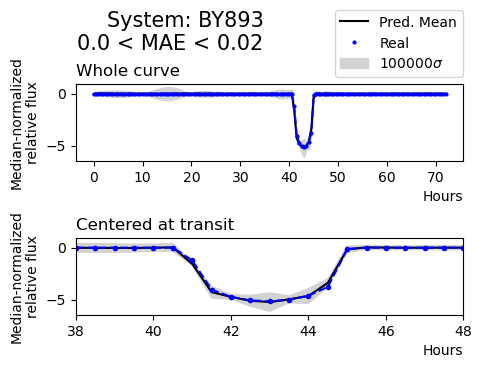

In [29]:
lower = 0.00
upper = 0.02
mask = (non_ringed_rec_err>lower) & (non_ringed_rec_err<upper)
i = 0


fig, ax = pl.subplots(2, 1)
t = np.linspace(0, 144, 145)/2
real = test_non_ringed_curves[mask][i]
pred = mean_predictions_non_ringed_curves[mask][i]
sigma = std_predictions_non_ringed_curves[mask][i]
ID = non_ringed_test_ids[mask][i]

mag = 100000
ax[0].plot(t, pred, label='Pred. Mean', c='black')
ax[0].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[0].plot(t, real, '.', markersize=4, c='b', label='Real')
ax[0].plot(t, real, '--', c='b')
ax[0].legend(loc='lower left', bbox_to_anchor=(0.65, 1))
ax[0].set_title('Whole curve', loc='left')
ax[0].set_xlabel('Hours', loc='right')
ax[0].set_ylabel('Median-normalized\nrelative flux')

ax[1].plot(t, pred, label='Pred. Mean', c='black')
ax[1].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[1].plot(t, real, '.', markersize=6, c='b', label='Real')
ax[1].plot(t, real, '--', c='b')
ax[1].set_title('Centered at transit' , loc='left')
ax[1].set_xlabel('Hours', loc='right')
ax[1].set_xlim(38, 48)
ax[1].set_ylabel('Median-normalized\nrelative flux')

pl.subplots_adjust(hspace=1)
fig.suptitle('System: '+ID+'\n'+str(lower)+' < MAE < '+str(upper), fontsize=15, ha='right', va='bottom')
fig.set_size_inches(5, 3)
fig.savefig('../../Figs/38-1.png')

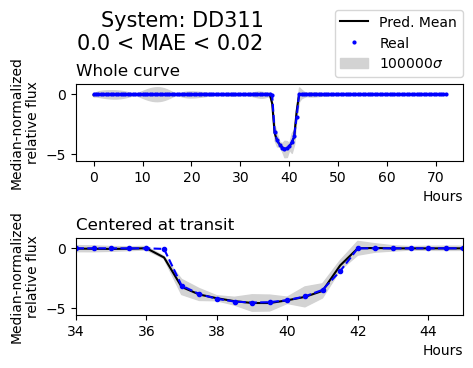

In [32]:
lower = 0.00
upper = 0.02
mask = (non_ringed_rec_err>lower) & (non_ringed_rec_err<upper)
i = 1


fig, ax = pl.subplots(2, 1)
t = np.linspace(0, 144, 145)/2
real = test_non_ringed_curves[mask][i]
pred = mean_predictions_non_ringed_curves[mask][i]
sigma = std_predictions_non_ringed_curves[mask][i]
ID = non_ringed_test_ids[mask][i]

mag = 100000
ax[0].plot(t, pred, label='Pred. Mean', c='black')
ax[0].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[0].plot(t, real, '.', markersize=4, c='b', label='Real')
ax[0].plot(t, real, '--', c='b')
ax[0].legend(loc='lower left', bbox_to_anchor=(0.65, 1))
ax[0].set_title('Whole curve', loc='left')
ax[0].set_xlabel('Hours', loc='right')
ax[0].set_ylabel('Median-normalized\nrelative flux')

ax[1].plot(t, pred, label='Pred. Mean', c='black')
ax[1].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[1].plot(t, real, '.', markersize=6, c='b', label='Real')
ax[1].plot(t, real, '--', c='b')
ax[1].set_title('Centered at transit' , loc='left')
ax[1].set_xlabel('Hours', loc='right')
ax[1].set_xlim(34, 45)
ax[1].set_ylabel('Median-normalized\nrelative flux')

pl.subplots_adjust(hspace=1)
fig.suptitle('System: '+ID+'\n'+str(lower)+' < MAE < '+str(upper), fontsize=15, ha='right', va='bottom')
fig.set_size_inches(5, 3)
fig.savefig('../../Figs/38-2.png')

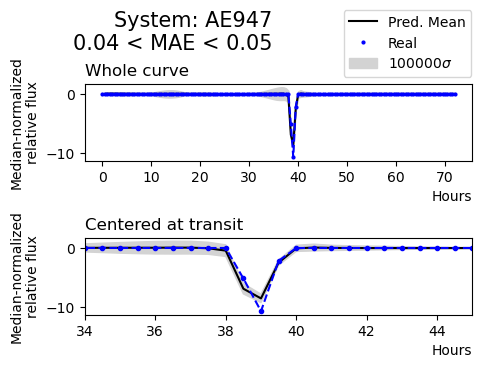

In [40]:
lower = 0.04
upper = 0.05
mask = (non_ringed_rec_err>lower) & (non_ringed_rec_err<upper)
i = 0


fig, ax = pl.subplots(2, 1)
t = np.linspace(0, 144, 145)/2
real = test_non_ringed_curves[mask][i]
pred = mean_predictions_non_ringed_curves[mask][i]
sigma = std_predictions_non_ringed_curves[mask][i]
ID = non_ringed_test_ids[mask][i]

mag = 100000
ax[0].plot(t, pred, label='Pred. Mean', c='black')
ax[0].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[0].plot(t, real, '.', markersize=4, c='b', label='Real')
ax[0].plot(t, real, '--', c='b')
ax[0].legend(loc='lower left', bbox_to_anchor=(0.65, 1))
ax[0].set_title('Whole curve', loc='left')
ax[0].set_xlabel('Hours', loc='right')
ax[0].set_ylabel('Median-normalized\nrelative flux')

ax[1].plot(t, pred, label='Pred. Mean', c='black')
ax[1].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[1].plot(t, real, '.', markersize=6, c='b', label='Real')
ax[1].plot(t, real, '--', c='b')
ax[1].set_title('Centered at transit' , loc='left')
ax[1].set_xlabel('Hours', loc='right')
ax[1].set_xlim(34, 45)
ax[1].set_ylabel('Median-normalized\nrelative flux')

pl.subplots_adjust(hspace=1)
fig.suptitle('System: '+ID+'\n'+str(lower)+' < MAE < '+str(upper), fontsize=15, ha='right', va='bottom')
fig.set_size_inches(5, 3)
fig.savefig('../../Figs/39-1.png')

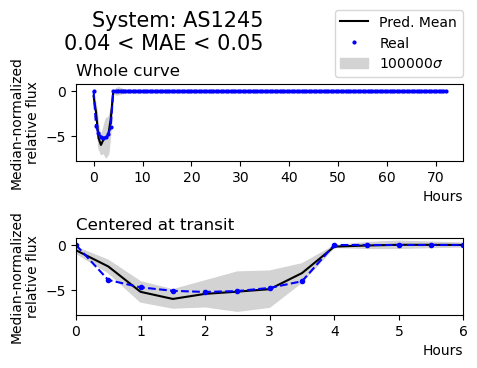

In [38]:
lower = 0.04
upper = 0.05
mask = (non_ringed_rec_err>lower) & (non_ringed_rec_err<upper)
i = 1


fig, ax = pl.subplots(2, 1)
t = np.linspace(0, 144, 145)/2
real = test_non_ringed_curves[mask][i]
pred = mean_predictions_non_ringed_curves[mask][i]
sigma = std_predictions_non_ringed_curves[mask][i]
ID = non_ringed_test_ids[mask][i]

mag = 100000
ax[0].plot(t, pred, label='Pred. Mean', c='black')
ax[0].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[0].plot(t, real, '.', markersize=4, c='b', label='Real')
ax[0].plot(t, real, '--', c='b')
ax[0].legend(loc='lower left', bbox_to_anchor=(0.65, 1))
ax[0].set_title('Whole curve', loc='left')
ax[0].set_xlabel('Hours', loc='right')
ax[0].set_ylabel('Median-normalized\nrelative flux')

ax[1].plot(t, pred, label='Pred. Mean', c='black')
ax[1].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[1].plot(t, real, '.', markersize=6, c='b', label='Real')
ax[1].plot(t, real, '--', c='b')
ax[1].set_title('Centered at transit' , loc='left')
ax[1].set_xlabel('Hours', loc='right')
ax[1].set_xlim(0, 6)
ax[1].set_ylabel('Median-normalized\nrelative flux')

pl.subplots_adjust(hspace=1)
fig.suptitle('System: '+ID+'\n'+str(lower)+' < MAE < '+str(upper), fontsize=15, ha='right', va='bottom')
fig.set_size_inches(5, 3)
fig.savefig('../../Figs/39-2.png')

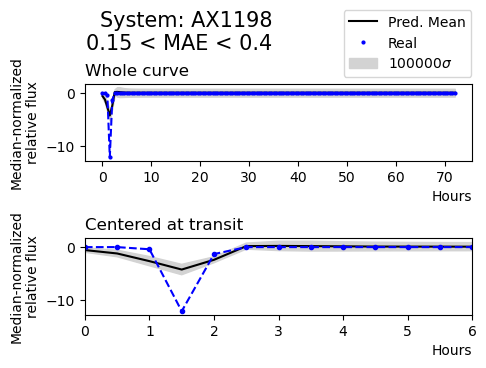

In [41]:
lower = 0.15
upper = 0.40
mask = (non_ringed_rec_err>lower) & (non_ringed_rec_err<upper)
i = 0


fig, ax = pl.subplots(2, 1)
t = np.linspace(0, 144, 145)/2
real = test_non_ringed_curves[mask][i]
pred = mean_predictions_non_ringed_curves[mask][i]
sigma = std_predictions_non_ringed_curves[mask][i]
ID = non_ringed_test_ids[mask][i]

mag = 100000
ax[0].plot(t, pred, label='Pred. Mean', c='black')
ax[0].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[0].plot(t, real, '.', markersize=4, c='b', label='Real')
ax[0].plot(t, real, '--', c='b')
ax[0].legend(loc='lower left', bbox_to_anchor=(0.65, 1))
ax[0].set_title('Whole curve', loc='left')
ax[0].set_xlabel('Hours', loc='right')
ax[0].set_ylabel('Median-normalized\nrelative flux')

ax[1].plot(t, pred, label='Pred. Mean', c='black')
ax[1].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[1].plot(t, real, '.', markersize=6, c='b', label='Real')
ax[1].plot(t, real, '--', c='b')
ax[1].set_title('Centered at transit' , loc='left')
ax[1].set_xlabel('Hours', loc='right')
ax[1].set_xlim(0, 6)
ax[1].set_ylabel('Median-normalized\nrelative flux')

pl.subplots_adjust(hspace=1)
fig.suptitle('System: '+ID+'\n'+str(lower)+' < MAE < '+str(upper), fontsize=15, ha='right', va='bottom')
fig.set_size_inches(5, 3)
fig.savefig('../../Figs/40-1.png')

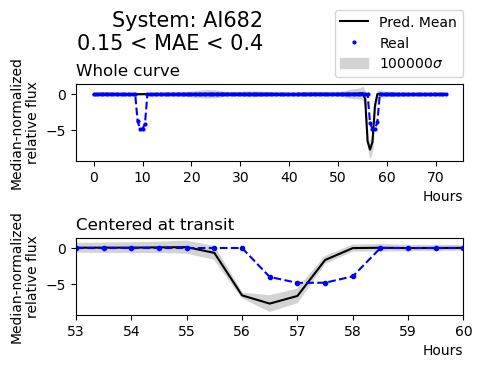

In [43]:
lower = 0.15
upper = 0.40
mask = (non_ringed_rec_err>lower) & (non_ringed_rec_err<upper)
i = 1


fig, ax = pl.subplots(2, 1)
t = np.linspace(0, 144, 145)/2
real = test_non_ringed_curves[mask][i]
pred = mean_predictions_non_ringed_curves[mask][i]
sigma = std_predictions_non_ringed_curves[mask][i]
ID = non_ringed_test_ids[mask][i]

mag = 100000
ax[0].plot(t, pred, label='Pred. Mean', c='black')
ax[0].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[0].plot(t, real, '.', markersize=4, c='b', label='Real')
ax[0].plot(t, real, '--', c='b')
ax[0].legend(loc='lower left', bbox_to_anchor=(0.65, 1))
ax[0].set_title('Whole curve', loc='left')
ax[0].set_xlabel('Hours', loc='right')
ax[0].set_ylabel('Median-normalized\nrelative flux')

ax[1].plot(t, pred, label='Pred. Mean', c='black')
ax[1].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[1].plot(t, real, '.', markersize=6, c='b', label='Real')
ax[1].plot(t, real, '--', c='b')
ax[1].set_title('Centered at transit' , loc='left')
ax[1].set_xlabel('Hours', loc='right')
ax[1].set_xlim(53, 60)
ax[1].set_ylabel('Median-normalized\nrelative flux')

pl.subplots_adjust(hspace=1)
fig.suptitle('System: '+ID+'\n'+str(lower)+' < MAE < '+str(upper), fontsize=15, ha='right', va='bottom')
fig.set_size_inches(5, 3)
fig.savefig('../../Figs/40-2.png')

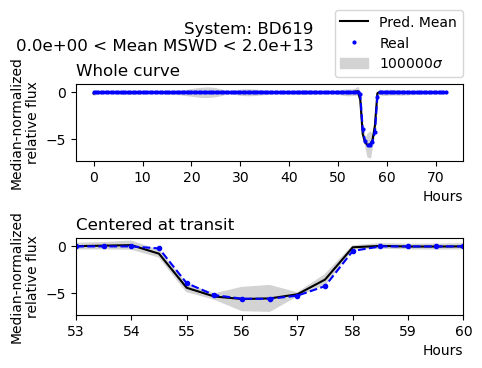

In [63]:
lower = 0.0
upper = 0.2e14
mask = (np.array(mean_MSWD_non_ringed)>lower) & (np.array(mean_MSWD_non_ringed)<upper)
i = 0


fig, ax = pl.subplots(2, 1)
t = np.linspace(0, 144, 145)/2
real = test_non_ringed_curves[mask][i]
pred = mean_predictions_non_ringed_curves[mask][i]
sigma = std_predictions_non_ringed_curves[mask][i]
ID = non_ringed_test_ids[mask][i]

mag = 100000
ax[0].plot(t, pred, label='Pred. Mean', c='black')
ax[0].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[0].plot(t, real, '.', markersize=4, c='b', label='Real')
ax[0].plot(t, real, '--', c='b')
ax[0].legend(loc='lower left', bbox_to_anchor=(0.65, 1))
ax[0].set_title('Whole curve', loc='left')
ax[0].set_xlabel('Hours', loc='right')
ax[0].set_ylabel('Median-normalized\nrelative flux')

ax[1].plot(t, pred, label='Pred. Mean', c='black')
ax[1].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[1].plot(t, real, '.', markersize=6, c='b', label='Real')
ax[1].plot(t, real, '--', c='b')
ax[1].set_title('Centered at transit' , loc='left')
ax[1].set_xlabel('Hours', loc='right')
ax[1].set_xlim(53, 60)
ax[1].set_ylabel('Median-normalized\nrelative flux')

pl.subplots_adjust(hspace=1)
fig.suptitle('System: '+ID+'\n'+f"{lower:.1e}"+' < Mean MSWD < '+f"{upper:.1e}", fontsize=12, ha='right', va='bottom', x=0.6)
fig.set_size_inches(5, 3)
fig.savefig('../../Figs/41-1.png')

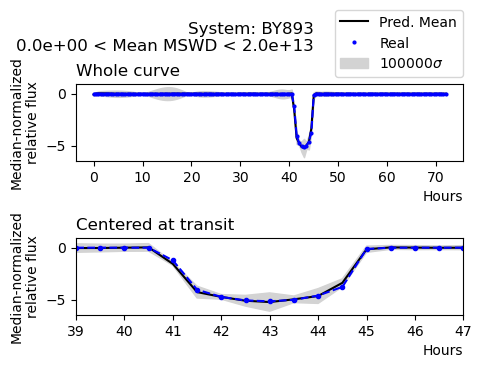

In [65]:
lower = 0.0
upper = 0.2e14
mask = (np.array(mean_MSWD_non_ringed)>lower) & (np.array(mean_MSWD_non_ringed)<upper)
i = 1


fig, ax = pl.subplots(2, 1)
t = np.linspace(0, 144, 145)/2
real = test_non_ringed_curves[mask][i]
pred = mean_predictions_non_ringed_curves[mask][i]
sigma = std_predictions_non_ringed_curves[mask][i]
ID = non_ringed_test_ids[mask][i]

mag = 100000
ax[0].plot(t, pred, label='Pred. Mean', c='black')
ax[0].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[0].plot(t, real, '.', markersize=4, c='b', label='Real')
ax[0].plot(t, real, '--', c='b')
ax[0].legend(loc='lower left', bbox_to_anchor=(0.65, 1))
ax[0].set_title('Whole curve', loc='left')
ax[0].set_xlabel('Hours', loc='right')
ax[0].set_ylabel('Median-normalized\nrelative flux')

ax[1].plot(t, pred, label='Pred. Mean', c='black')
ax[1].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[1].plot(t, real, '.', markersize=6, c='b', label='Real')
ax[1].plot(t, real, '--', c='b')
ax[1].set_title('Centered at transit' , loc='left')
ax[1].set_xlabel('Hours', loc='right')
ax[1].set_xlim(39, 47)
ax[1].set_ylabel('Median-normalized\nrelative flux')

pl.subplots_adjust(hspace=1)
fig.suptitle('System: '+ID+'\n'+f"{lower:.1e}"+' < Mean MSWD < '+f"{upper:.1e}", fontsize=12, ha='right', va='bottom', x=0.6)
fig.set_size_inches(5, 3)
fig.savefig('../../Figs/41-2.png')

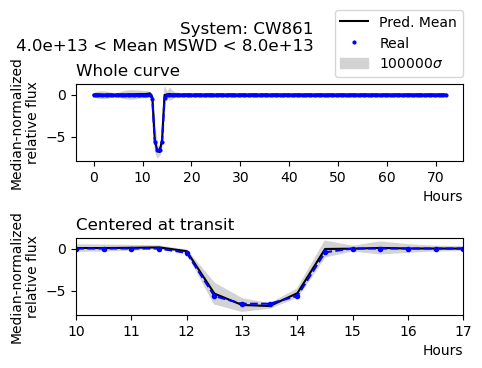

In [74]:
lower = 0.4e14
upper = 0.8e14
mask = (np.array(mean_MSWD_non_ringed)>lower) & (np.array(mean_MSWD_non_ringed)<upper)
i = 0


fig, ax = pl.subplots(2, 1)
t = np.linspace(0, 144, 145)/2
real = test_non_ringed_curves[mask][i]
pred = mean_predictions_non_ringed_curves[mask][i]
sigma = std_predictions_non_ringed_curves[mask][i]
ID = non_ringed_test_ids[mask][i]

mag = 100000
ax[0].plot(t, pred, label='Pred. Mean', c='black')
ax[0].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[0].plot(t, real, '.', markersize=4, c='b', label='Real')
ax[0].plot(t, real, '--', c='b')
ax[0].legend(loc='lower left', bbox_to_anchor=(0.65, 1))
ax[0].set_title('Whole curve', loc='left')
ax[0].set_xlabel('Hours', loc='right')
ax[0].set_ylabel('Median-normalized\nrelative flux')

ax[1].plot(t, pred, label='Pred. Mean', c='black')
ax[1].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[1].plot(t, real, '.', markersize=6, c='b', label='Real')
ax[1].plot(t, real, '--', c='b')
ax[1].set_title('Centered at transit' , loc='left')
ax[1].set_xlabel('Hours', loc='right')
ax[1].set_xlim(10, 17)
ax[1].set_ylabel('Median-normalized\nrelative flux')

pl.subplots_adjust(hspace=1)
fig.suptitle('System: '+ID+'\n'+f"{lower:.1e}"+' < Mean MSWD < '+f"{upper:.1e}", fontsize=12, ha='right', va='bottom', x=0.6)
fig.set_size_inches(5, 3)
fig.savefig('../../Figs/42-1.png')

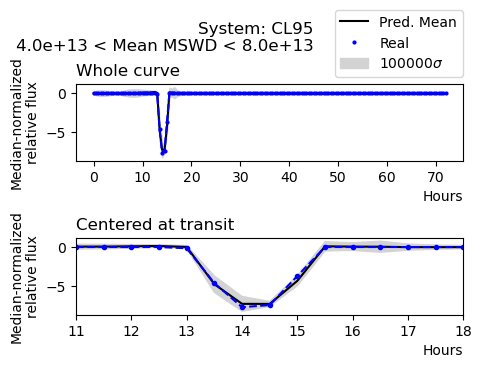

In [75]:
lower = 0.4e14
upper = 0.8e14
mask = (np.array(mean_MSWD_non_ringed)>lower) & (np.array(mean_MSWD_non_ringed)<upper)
i = 1


fig, ax = pl.subplots(2, 1)
t = np.linspace(0, 144, 145)/2
real = test_non_ringed_curves[mask][i]
pred = mean_predictions_non_ringed_curves[mask][i]
sigma = std_predictions_non_ringed_curves[mask][i]
ID = non_ringed_test_ids[mask][i]

mag = 100000
ax[0].plot(t, pred, label='Pred. Mean', c='black')
ax[0].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[0].plot(t, real, '.', markersize=4, c='b', label='Real')
ax[0].plot(t, real, '--', c='b')
ax[0].legend(loc='lower left', bbox_to_anchor=(0.65, 1))
ax[0].set_title('Whole curve', loc='left')
ax[0].set_xlabel('Hours', loc='right')
ax[0].set_ylabel('Median-normalized\nrelative flux')

ax[1].plot(t, pred, label='Pred. Mean', c='black')
ax[1].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[1].plot(t, real, '.', markersize=6, c='b', label='Real')
ax[1].plot(t, real, '--', c='b')
ax[1].set_title('Centered at transit' , loc='left')
ax[1].set_xlabel('Hours', loc='right')
ax[1].set_xlim(11, 18)
ax[1].set_ylabel('Median-normalized\nrelative flux')

pl.subplots_adjust(hspace=1)
fig.suptitle('System: '+ID+'\n'+f"{lower:.1e}"+' < Mean MSWD < '+f"{upper:.1e}", fontsize=12, ha='right', va='bottom', x=0.6)
fig.set_size_inches(5, 3)
fig.savefig('../../Figs/42-2.png')

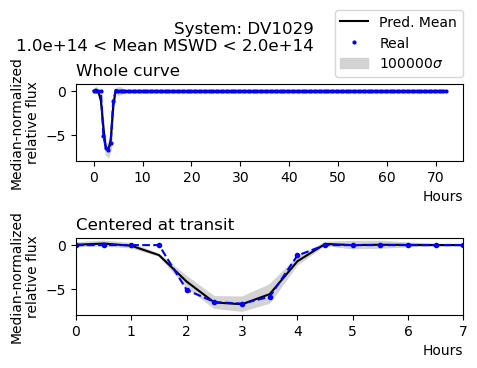

In [87]:
lower = 1.0e14
upper = 2.0e14
mask = (np.array(mean_MSWD_non_ringed)>lower) & (np.array(mean_MSWD_non_ringed)<upper)
i = 0


fig, ax = pl.subplots(2, 1)
t = np.linspace(0, 144, 145)/2
real = test_non_ringed_curves[mask][i]
pred = mean_predictions_non_ringed_curves[mask][i]
sigma = std_predictions_non_ringed_curves[mask][i]
ID = non_ringed_test_ids[mask][i]

mag = 100000
ax[0].plot(t, pred, label='Pred. Mean', c='black')
ax[0].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[0].plot(t, real, '.', markersize=4, c='b', label='Real')
ax[0].plot(t, real, '--', c='b')
ax[0].legend(loc='lower left', bbox_to_anchor=(0.65, 1))
ax[0].set_title('Whole curve', loc='left')
ax[0].set_xlabel('Hours', loc='right')
ax[0].set_ylabel('Median-normalized\nrelative flux')

ax[1].plot(t, pred, label='Pred. Mean', c='black')
ax[1].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[1].plot(t, real, '.', markersize=6, c='b', label='Real')
ax[1].plot(t, real, '--', c='b')
ax[1].set_title('Centered at transit' , loc='left')
ax[1].set_xlabel('Hours', loc='right')
ax[1].set_xlim(0, 7)
ax[1].set_ylabel('Median-normalized\nrelative flux')

pl.subplots_adjust(hspace=1)
fig.suptitle('System: '+ID+'\n'+f"{lower:.1e}"+' < Mean MSWD < '+f"{upper:.1e}", fontsize=12, ha='right', va='bottom', x=0.6)
fig.set_size_inches(5, 3)
fig.savefig('../../Figs/43-1.png')

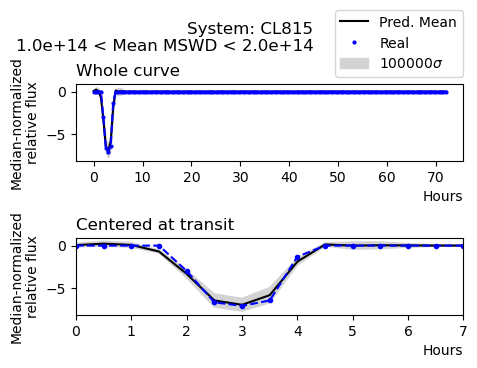

In [92]:
lower = 1.0e14
upper = 2.0e14
mask = (np.array(mean_MSWD_non_ringed)>lower) & (np.array(mean_MSWD_non_ringed)<upper)
i = 1


fig, ax = pl.subplots(2, 1)
t = np.linspace(0, 144, 145)/2
real = test_non_ringed_curves[mask][i]
pred = mean_predictions_non_ringed_curves[mask][i]
sigma = std_predictions_non_ringed_curves[mask][i]
ID = non_ringed_test_ids[mask][i]

mag = 100000
ax[0].plot(t, pred, label='Pred. Mean', c='black')
ax[0].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[0].plot(t, real, '.', markersize=4, c='b', label='Real')
ax[0].plot(t, real, '--', c='b')
ax[0].legend(loc='lower left', bbox_to_anchor=(0.65, 1))
ax[0].set_title('Whole curve', loc='left')
ax[0].set_xlabel('Hours', loc='right')
ax[0].set_ylabel('Median-normalized\nrelative flux')

ax[1].plot(t, pred, label='Pred. Mean', c='black')
ax[1].fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax[1].plot(t, real, '.', markersize=6, c='b', label='Real')
ax[1].plot(t, real, '--', c='b')
ax[1].set_title('Centered at transit' , loc='left')
ax[1].set_xlabel('Hours', loc='right')
ax[1].set_xlim(0, 7)
ax[1].set_ylabel('Median-normalized\nrelative flux')

pl.subplots_adjust(hspace=1)
fig.suptitle('System: '+ID+'\n'+f"{lower:.1e}"+' < Mean MSWD < '+f"{upper:.1e}", fontsize=12, ha='right', va='bottom', x=0.6)
fig.set_size_inches(5, 3)
fig.savefig('../../Figs/43-2.png')

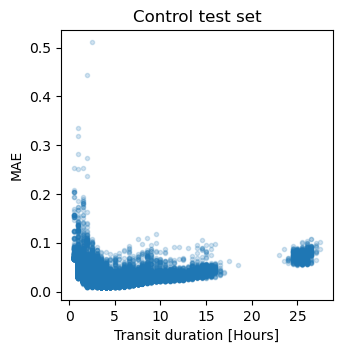

In [105]:
fig, ax = pl.subplots(1,1)
ax.plot(non_ringed_durations_test, non_ringed_rec_err, '.', alpha=0.2)
ax.set_xlabel('Transit duration [Hours]')
ax.set_ylabel('MAE')
ax.set_title('Control test set')
fig.set_size_inches(3.5, 3.5)
fig.savefig('../../Figs/41-o-1.png')


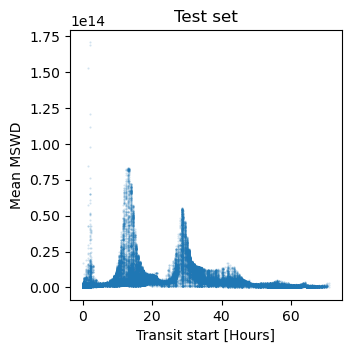

In [146]:
fig, ax = pl.subplots(1,1)
ax.plot(non_ringed_transit_starts, mean_MSWD_non_ringed, '.', alpha=0.2, markersize=1)
ax.set_xlabel('Transit start [Hours]')
ax.set_ylabel('Mean MSWD')
ax.set_title('Test set')
fig.set_size_inches(3.5, 3.5)
fig.savefig('../../Figs/45-1.png')

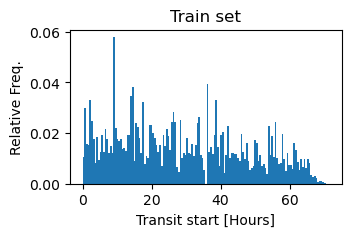

In [151]:
fig, ax = pl.subplots(1,1)
ax.hist(non_ringed_transit_starts_train, bins=145, density=True)
ax.set_xlabel('Transit start [Hours]')
ax.set_ylabel('Relative Freq.')
ax.set_title('Train set')
fig.set_size_inches(3.5, 2)
fig.savefig('../../Figs/46-1.png')

In [28]:
A_letters = np.array([s[:2] for s in A_ringed_ids])
B_letters = np.array([s[:2] for s in B_ringed_ids])
C_letters = np.array([s[:2] for s in C_ringed_ids])
D_letters = np.array([s[:2] for s in D_ringed_ids])
E_letters = np.array([s[:2] for s in E_ringed_ids])
F_letters = np.array([s[:2] for s in F_ringed_ids])

In [31]:
same_AB = np.where(B_letters==A_letters[0])[0][0]
same_CD = np.where(D_letters==C_letters[0])[0][0]
same_EF = np.where(F_letters==E_letters[0])[0][0]

In [34]:
same_EF

3

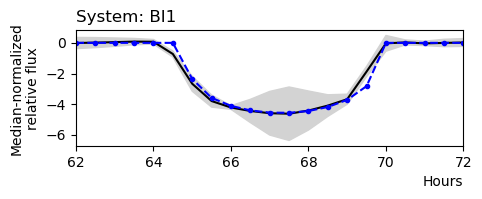

In [48]:
i = 0


fig, ax = pl.subplots(1, 1)
t = np.linspace(0, 144, 145)/2
real = A_test_ringed_curves[i]
pred = A_mean_predictions_ringed_curves[i]
sigma = A_std_predictions_ringed_curves[i]
ID = A_ringed_ids[i]
mag = 100000


ax.plot(t, pred, label='Pred. Mean', c='black')
ax.fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax.plot(t, real, '.', markersize=6, c='b', label='Real')
ax.plot(t, real, '--', c='b')
ax.set_title('System: '+ID , loc='left')
ax.set_xlabel('Hours', loc='right')
ax.set_xlim(62, 72)
ax.set_ylabel('Median-normalized\nrelative flux')

fig.set_size_inches(5, 1.5)
fig.savefig('../../Figs/43b-1.png')

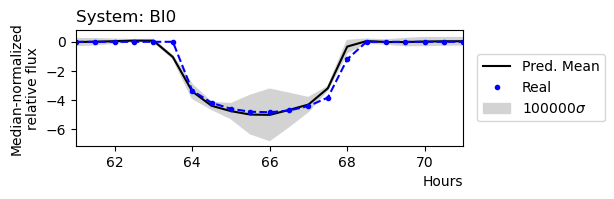

In [68]:
i = same_AB


fig, ax = pl.subplots(1, 1)
t = np.linspace(0, 144, 145)/2
real = B_test_ringed_curves[i]
pred = B_mean_predictions_ringed_curves[i]
sigma = B_std_predictions_ringed_curves[i]
ID = B_ringed_ids[i]
mag = 100000


ax.plot(t, pred, label='Pred. Mean', c='black')
ax.fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax.plot(t, real, '.', markersize=6, c='b', label='Real')
ax.plot(t, real, '--', c='b')
ax.set_title('System: '+ID , loc='left')
ax.set_xlabel('Hours', loc='right')
ax.set_xlim(61, 71)
ax.set_ylabel('Median-normalized\nrelative flux')
ax.legend(loc='center', bbox_to_anchor=(1.2, 0.5))
fig.set_size_inches(5, 1.5)
fig.savefig('../../Figs/43b-2.png')

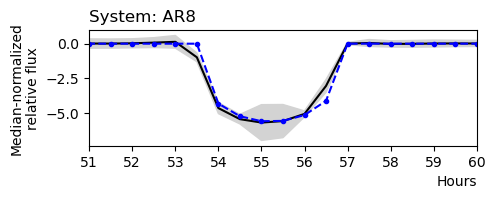

In [56]:
i = 0


fig, ax = pl.subplots(1, 1)
t = np.linspace(0, 144, 145)/2
real = C_test_ringed_curves[i]
pred = C_mean_predictions_ringed_curves[i]
sigma = C_std_predictions_ringed_curves[i]
ID = C_ringed_ids[i]
mag = 100000


ax.plot(t, pred, label='Pred. Mean', c='black')
ax.fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax.plot(t, real, '.', markersize=6, c='b', label='Real')
ax.plot(t, real, '--', c='b')
ax.set_title('System: '+ID , loc='left')
ax.set_xlabel('Hours', loc='right')
ax.set_xlim(51, 60)
ax.set_ylabel('Median-normalized\nrelative flux')

fig.set_size_inches(5, 1.5)
fig.savefig('../../Figs/43b-3.png')

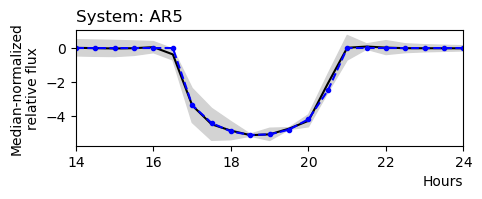

In [70]:
i = same_CD


fig, ax = pl.subplots(1, 1)
t = np.linspace(0, 144, 145)/2
real = D_test_ringed_curves[i]
pred = D_mean_predictions_ringed_curves[i]
sigma = D_std_predictions_ringed_curves[i]
ID = D_ringed_ids[i]
mag = 100000


ax.plot(t, pred, label='Pred. Mean', c='black')
ax.fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax.plot(t, real, '.', markersize=6, c='b', label='Real')
ax.plot(t, real, '--', c='b')
ax.set_title('System: '+ID , loc='left')
ax.set_xlabel('Hours', loc='right')
ax.set_xlim(14, 24)
ax.set_ylabel('Median-normalized\nrelative flux')

fig.set_size_inches(5, 1.5)
fig.savefig('../../Figs/43b-4.png')

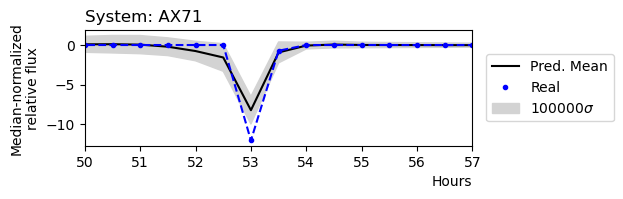

In [74]:
i = 0


fig, ax = pl.subplots(1, 1)
t = np.linspace(0, 144, 145)/2
real = E_test_ringed_curves[i]
pred = E_mean_predictions_ringed_curves[i]
sigma = E_std_predictions_ringed_curves[i]
ID = E_ringed_ids[i]
mag = 100000


ax.plot(t, pred, label='Pred. Mean', c='black')
ax.fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax.plot(t, real, '.', markersize=6, c='b', label='Real')
ax.plot(t, real, '--', c='b')
ax.set_title('System: '+ID , loc='left')
ax.set_xlabel('Hours', loc='right')
ax.set_xlim(50, 57)
ax.set_ylabel('Median-normalized\nrelative flux')
ax.legend(loc='center', bbox_to_anchor=(1.2, 0.5))
fig.set_size_inches(5, 1.5)
fig.savefig('../../Figs/43b-5.png')

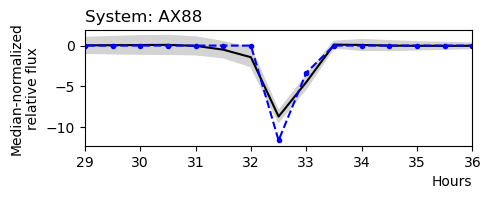

In [79]:
i = same_EF


fig, ax = pl.subplots(1, 1)
t = np.linspace(0, 144, 145)/2
real = F_test_ringed_curves[i]
pred = F_mean_predictions_ringed_curves[i]
sigma = F_std_predictions_ringed_curves[i]
ID = F_ringed_ids[i]
mag = 100000


ax.plot(t, pred, label='Pred. Mean', c='black')
ax.fill_between(t, pred-mag*sigma, pred+mag*sigma, color='lightgray', label=str(mag)+'$\sigma$')
ax.plot(t, real, '.', markersize=6, c='b', label='Real')
ax.plot(t, real, '--', c='b')
ax.set_title('System: '+ID , loc='left')
ax.set_xlabel('Hours', loc='right')
ax.set_xlim(29, 36)
ax.set_ylabel('Median-normalized\nrelative flux')

fig.set_size_inches(5, 1.5)
fig.savefig('../../Figs/43b-6.png')

In [21]:
trandur_ids = []
trandur_ids.append(non_ringed_test_ids[(non_ringed_durations_test>=2) & (non_ringed_durations_test<=3)][0])
trandur_ids.append(non_ringed_test_ids[(non_ringed_durations_test>=4) & (non_ringed_durations_test<=6)][0])
trandur_ids.append(non_ringed_test_ids[(non_ringed_durations_test>=7) & (non_ringed_durations_test<=8)][0])
trandur_ids.append(non_ringed_test_ids[(non_ringed_durations_test>=9) & (non_ringed_durations_test<=11)][0])
trandur_ids.append(non_ringed_test_ids[(non_ringed_durations_test>=14) & (non_ringed_durations_test<=16)][0])
trandur_ids.append(non_ringed_test_ids[(non_ringed_durations_test>=23) & (non_ringed_durations_test<=27)][0])

print(trandur_ids)

['AT861', 'BD619', 'AK623', 'CR1012', 'AQ1382', 'AB1153']


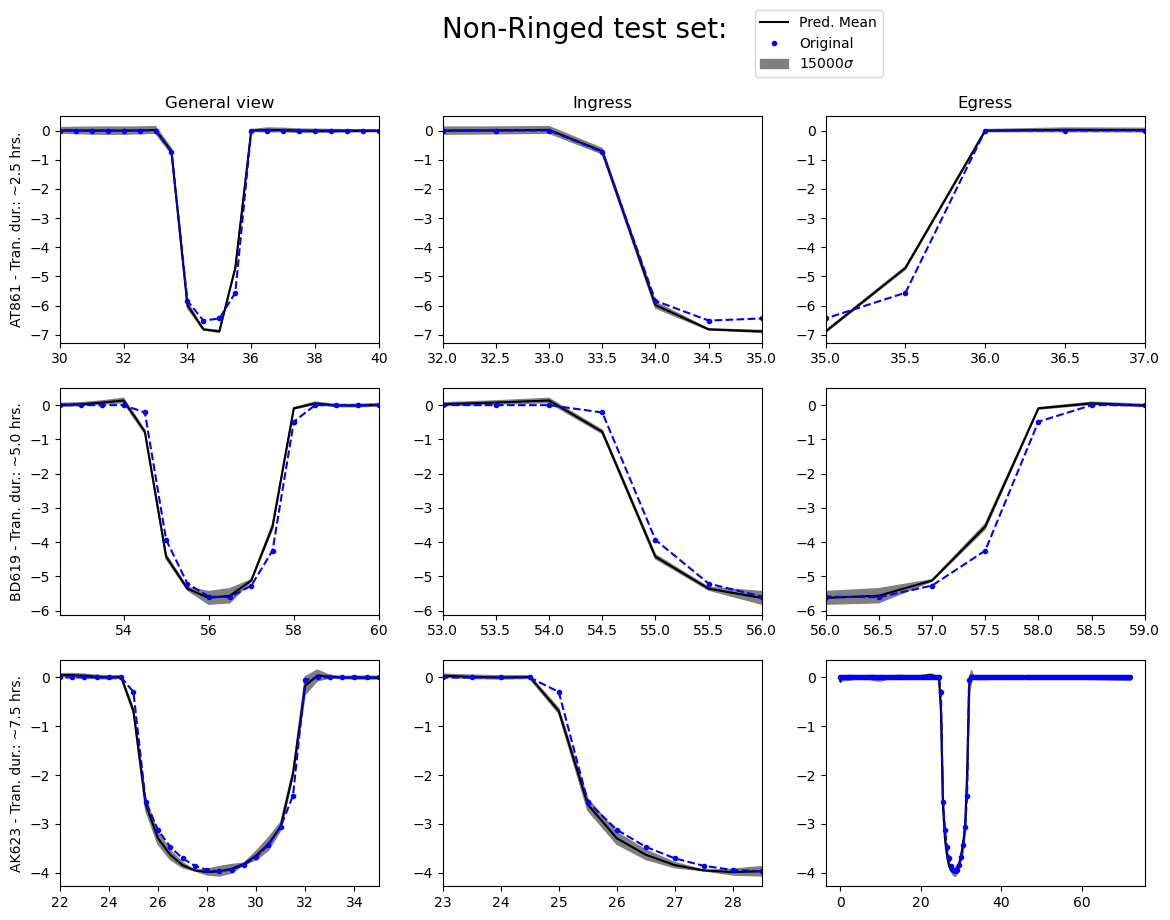

In [22]:
fig, axes = pl.subplots(3, 3)

c_mean='black'
c_std='gray'
c_real = 'b'
std_mag = 15000

mask = (non_ringed_test_ids==trandur_ids[0]) #2.5
real = test_non_ringed_curves[mask][0]
mean_pred = mean_predictions_non_ringed_curves[mask][0]
std_pred = std_predictions_non_ringed_curves[mask][0]
x = np.linspace(0, 144, 145)/2

axes[0, 0].set_title('General view')                                                
axes[0, 0].plot(x, mean_pred, c=c_mean)
axes[0, 0].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std)
axes[0, 0].plot(x, real, '.', c=c_real)
axes[0, 0].plot(x, real, '--', c=c_real)
axes[0, 0].set_xlim(30, 40)
axes[0, 0].set_ylabel(trandur_ids[0]+' - Tran. dur.: ~2.5 hrs.')

axes[0, 1].set_title('Ingress')
axes[0, 1].plot(x, mean_pred, c=c_mean)
axes[0, 1].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std)
axes[0, 1].plot(x, real, '.', c=c_real)
axes[0, 1].plot(x, real, '--', c=c_real)
axes[0, 1].set_xlim(32, 35)

axes[0, 2].set_title('Egress')
axes[0, 2].plot(x, mean_pred, c=c_mean, label='Pred. Mean')
axes[0, 2].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std, label=str(std_mag)+"$\sigma$")
axes[0, 2].plot(x, real, '.', c=c_real, label='Original')
axes[0, 2].plot(x, real, '--', c=c_real)
axes[0, 2].set_xlim(35, 37)




mask = (non_ringed_test_ids==trandur_ids[1]) #5.0
real = test_non_ringed_curves[mask][0]
mean_pred = mean_predictions_non_ringed_curves[mask][0]
std_pred = std_predictions_non_ringed_curves[mask][0]
x = np.linspace(0, 144, 145)/2
                                                
axes[1, 0].plot(x, mean_pred, c=c_mean)
axes[1, 0].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std)
axes[1, 0].plot(x, real, '.', c=c_real)
axes[1, 0].plot(x, real, '--', c=c_real)
axes[1, 0].set_xlim(52.5, 60)
axes[1, 0].set_ylabel(trandur_ids[1]+' - Tran. dur.: ~5.0 hrs.')

axes[1, 1].plot(x, mean_pred, c=c_mean)
axes[1, 1].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std)
axes[1, 1].plot(x, real, '.', c=c_real)
axes[1, 1].plot(x, real, '--', c=c_real)
axes[1, 1].set_xlim(53, 56)

axes[1, 2].plot(x, mean_pred, c=c_mean, label='Pred. Mean')
axes[1, 2].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std, label=str(std_mag)+"$\sigma$")
axes[1, 2].plot(x, real, '.', c=c_real, label='Original')
axes[1, 2].plot(x, real, '--', c=c_real)
axes[1, 2].set_xlim(56, 59)


mask = (non_ringed_test_ids==trandur_ids[2]) #7.5
real = test_non_ringed_curves[mask][0]
mean_pred = mean_predictions_non_ringed_curves[mask][0]
std_pred = std_predictions_non_ringed_curves[mask][0]
x = np.linspace(0, 144, 145)/2
                                                
axes[2, 0].plot(x, mean_pred, c=c_mean)
axes[2, 0].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std)
axes[2, 0].plot(x, real, '.', c=c_real)
axes[2, 0].plot(x, real, '--', c=c_real)
axes[2, 0].set_xlim(22, 35)
axes[2, 0].set_ylabel(trandur_ids[2]+' - Tran. dur.: ~7.5 hrs.')

axes[2, 1].plot(x, mean_pred, c=c_mean)
axes[2, 1].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std)
axes[2, 1].plot(x, real, '.', c=c_real)
axes[2, 1].plot(x, real, '--', c=c_real)
axes[2, 1].set_xlim(23, 28.5)

axes[2, 2].plot(x, mean_pred, c=c_mean, label='Pred. Mean')
axes[2, 2].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std, label=str(std_mag)+"$\sigma$")
axes[2, 2].plot(x, real, '.', c=c_real, label='Original')
axes[2, 2].plot(x, real, '--', c=c_real)
#axes[2, 2].set_xlim(32, 38)



axes[0, 2].legend(bbox_to_anchor=(0.2, 1.5), fontsize='10')
fig.suptitle('Non-Ringed test set:', fontsize=20)
fig.set_size_inches(14, 10)

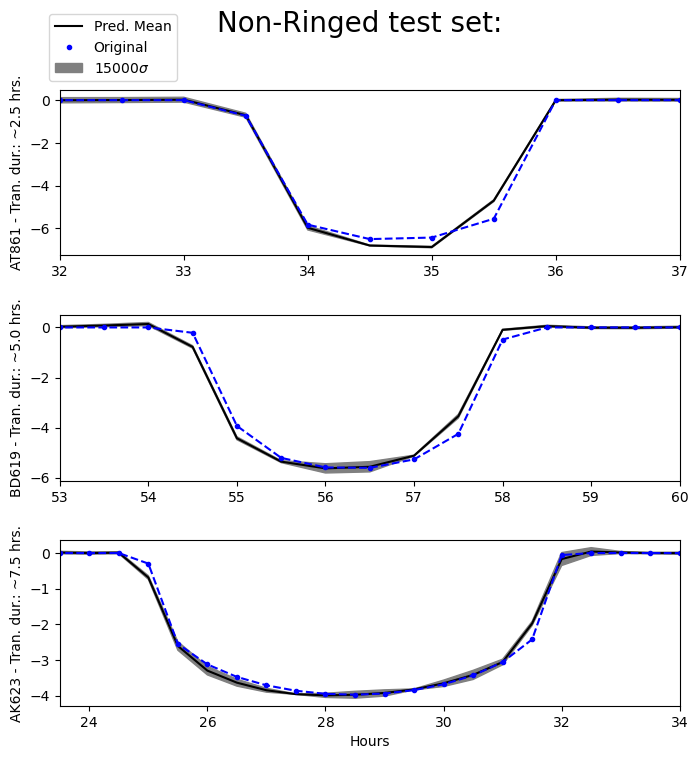

In [23]:
fig, axes = pl.subplots(3, 1)

c_mean='black'
c_std='gray'
c_real = 'b'
std_mag = 15000

mask = (non_ringed_test_ids==trandur_ids[0]) #2.5
real = test_non_ringed_curves[mask][0]
mean_pred = mean_predictions_non_ringed_curves[mask][0]
std_pred = std_predictions_non_ringed_curves[mask][0]
x = np.linspace(0, 144, 145)/2
                                               
axes[0].plot(x, mean_pred, c=c_mean, label='Pred. Mean')
axes[0].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std, label=str(std_mag)+"$\sigma$")
axes[0].plot(x, real, '.', c=c_real,label='Original' )
axes[0].plot(x, real, '--', c=c_real)
axes[0].set_xlim(32, 37)
axes[0].set_ylabel(trandur_ids[0]+' - Tran. dur.: ~2.5 hrs.')

mask = (non_ringed_test_ids==trandur_ids[1]) #5.0
real = test_non_ringed_curves[mask][0]
mean_pred = mean_predictions_non_ringed_curves[mask][0]
std_pred = std_predictions_non_ringed_curves[mask][0]
x = np.linspace(0, 144, 145)/2
                                                
axes[1].plot(x, mean_pred, c=c_mean)
axes[1].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std)
axes[1].plot(x, real, '.', c=c_real)
axes[1].plot(x, real, '--', c=c_real)
axes[1].set_xlim(53, 60)
axes[1].set_ylabel(trandur_ids[1]+' - Tran. dur.: ~5.0 hrs.')

mask = (non_ringed_test_ids==trandur_ids[2]) #7.5
real = test_non_ringed_curves[mask][0]
mean_pred = mean_predictions_non_ringed_curves[mask][0]
std_pred = std_predictions_non_ringed_curves[mask][0]
x = np.linspace(0, 144, 145)/2
                                                
axes[2].plot(x, mean_pred, c=c_mean)
axes[2].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std)
axes[2].plot(x, real, '.', c=c_real)
axes[2].plot(x, real, '--', c=c_real)
axes[2].set_xlim(23.5, 34)
axes[2].set_ylabel(trandur_ids[2]+' - Tran. dur.: ~7.5 hrs.')
axes[2].set_xlabel('Hours')

axes[0].legend(bbox_to_anchor=(0.2, 1.5), fontsize='10')
pl.subplots_adjust(hspace=0.36)

fig.suptitle('Non-Ringed test set:', fontsize=20)
fig.set_size_inches(8, 8)
                    

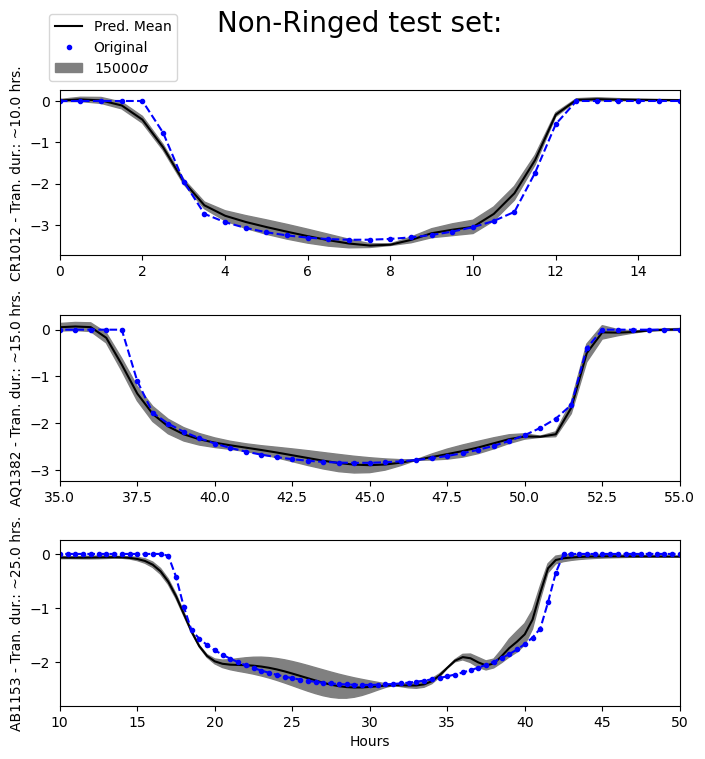

In [24]:
fig, axes = pl.subplots(3, 1)

c_mean='black'
c_std='gray'
c_real = 'b'
std_mag = 15000

mask = (non_ringed_test_ids==trandur_ids[3]) #10.0
real = test_non_ringed_curves[mask][0]
mean_pred = mean_predictions_non_ringed_curves[mask][0]
std_pred = std_predictions_non_ringed_curves[mask][0]
x = np.linspace(0, 144, 145)/2
                                               
axes[0].plot(x, mean_pred, c=c_mean, label='Pred. Mean')
axes[0].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std, label=str(std_mag)+"$\sigma$")
axes[0].plot(x, real, '.', c=c_real,label='Original' )
axes[0].plot(x, real, '--', c=c_real)
axes[0].set_xlim(0, 15)
axes[0].set_ylabel(trandur_ids[3]+' - Tran. dur.: ~10.0 hrs.')

mask = (non_ringed_test_ids==trandur_ids[4]) #15.0
real = test_non_ringed_curves[mask][0]
mean_pred = mean_predictions_non_ringed_curves[mask][0]
std_pred = std_predictions_non_ringed_curves[mask][0]
x = np.linspace(0, 144, 145)/2
                                                
axes[1].plot(x, mean_pred, c=c_mean)
axes[1].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std)
axes[1].plot(x, real, '.', c=c_real)
axes[1].plot(x, real, '--', c=c_real)
axes[1].set_xlim(35, 55)
axes[1].set_ylabel(trandur_ids[4]+' - Tran. dur.: ~15.0 hrs.')

mask = (non_ringed_test_ids==trandur_ids[5]) #25.0
real = test_non_ringed_curves[mask][0]
mean_pred = mean_predictions_non_ringed_curves[mask][0]
std_pred = std_predictions_non_ringed_curves[mask][0]
x = np.linspace(0, 144, 145)/2
                                                
axes[2].plot(x, mean_pred, c=c_mean)
axes[2].fill_between(x, mean_pred-std_mag*std_pred, mean_pred + std_mag*std_pred, color=c_std)
axes[2].plot(x, real, '.', c=c_real)
axes[2].plot(x, real, '--', c=c_real)
axes[2].set_xlim(10, 50)
axes[2].set_ylabel(trandur_ids[5]+' - Tran. dur.: ~25.0 hrs.')
axes[2].set_xlabel('Hours')

axes[0].legend(bbox_to_anchor=(0.2, 1.5), fontsize='10')
pl.subplots_adjust(hspace=0.36)
fig.suptitle('Non-Ringed test set:', fontsize=20)
fig.set_size_inches(8, 8)